# 0.0 IMPORTS

In [2]:
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import matplotlib.pyplot as plt 
import sweetviz as sv
import scikitplot as skplt
import lightgbm as lgb
import warnings
import pickle

from xgboost import XGBClassifier
from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn import model_selection as ms
from sklearn import metrics as mt
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier, RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from boruta import BorutaPy

warnings.filterwarnings('ignore')

C:\Users\edils\anaconda3\envs\health_insurance\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Loading Data

In [3]:
path = 'C:/Users/edils/repos/pa004_health_insurance/data/'

In [4]:
df_raw = pd.read_csv(path + 'train.csv')

In [5]:
y_raw = df_raw['Response']
df_raw = df_raw.drop(columns='Response')

In [6]:
df_raw_splitted, X_test, y_raw_splitted, y_test = ms.train_test_split(df_raw, y_raw, test_size=0.2, random_state=42)

In [7]:
df_raw = df_raw_splitted
df_raw['Response'] = y_raw_splitted

In [8]:
df_raw

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
332803,332804,Female,39,1,15.0,0,1-2 Year,Yes,52906.0,55.0,227,1
116248,116249,Male,38,1,11.0,0,1-2 Year,Yes,23038.0,26.0,29,0
255005,255006,Male,22,1,30.0,1,< 1 Year,No,45318.0,152.0,166,0
317474,317475,Female,23,1,41.0,1,< 1 Year,No,29132.0,151.0,277,0
344212,344213,Male,56,1,48.0,0,> 2 Years,Yes,2630.0,154.0,155,0
...,...,...,...,...,...,...,...,...,...,...,...,...
259178,259179,Female,24,1,36.0,1,< 1 Year,No,22575.0,152.0,287,0
365838,365839,Male,56,1,35.0,0,1-2 Year,Yes,41287.0,124.0,298,0
131932,131933,Female,22,1,2.0,0,< 1 Year,Yes,18857.0,152.0,76,0
146867,146868,Male,44,1,32.0,1,1-2 Year,Yes,2630.0,156.0,51,0


In [9]:
#X_test.to_csv('test.csv', index=False)

## 0.2 Helper Functions

In [10]:
def cramer_v( x, y ):
  cm = pd.crosstab( x, y ).to_numpy()
  n = cm.sum()
  r, k = cm.shape

  chi2 = stats.chi2_contingency( cm )[0]
  chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)
  return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def precision_at_k(df8, k, yhat):
    df8['id'] = df8.index + 1
    df8['score'] = yhat[:,1]
    df8 = df8.sort_values(by='score', ascending=False)
    df8 = df8.reset_index(drop=True)
    dfk = df8.iloc[:k, :]
    soma_total = dfk['response'].shape[0]
    soma_acertos = dfk['response'].sum()
    precision_at_k = soma_acertos/soma_total
    return precision_at_k

def recall_at_k(df8, k, yhat):
    df8['id'] = df8.index + 1
    df8['score'] = yhat[:,1]
    df8 = df8.sort_values(by='score', ascending=False)
    df8 = df8.reset_index(drop=True)
    dfk = df8.iloc[:k, :]
    soma_total = (df8['response'] == 1).sum()
    soma_acertos = dfk['response'].sum()
    recall_at_k = soma_acertos/soma_total
    return recall_at_k

def model_metrics(model_name, y, yhat, x_validation):
    precision = precision_at_k(x_validation, 4000, yhat)
    recall = recall_at_k(x_validation, 4000, yhat)
    f1_score = 2*(precision*recall)/(precision+recall)
    acc_score = mt.top_k_accuracy_score(y, yhat[:,1], k=1)
    auc_score = mt.roc_auc_score(y, yhat[:,1])
    
    return pd.DataFrame({'Model Name': model_name,
                         'Precisão at K': precision,
                         'Recall at K': recall,
                         'F1 at K': f1_score,
                         'Acurácia at K': acc_score,
                         'ROC AUC at K': auc_score}, index=[0])

def cross_validation(X, y, k_folds, model_name, model):

    df_list = []
    df_concat = pd.DataFrame()
    
    for k in range(k_folds):
        
        x_train_cv, x_val_cv, y_train_cv, y_val_cv = ms.train_test_split(X, y, test_size=0.2, random_state=k)

        x_train_cv = x_train_cv.loc[:,cols_selected]
        x_val_cv = x_val_cv.loc[:,cols_selected]

        x_validation_cv = x_val_cv.copy()
        x_validation_cv['response'] = y_val_cv.copy()

        #model
        m = model

        #training
        m.fit(x_train_cv, y_train_cv)

        #prediction
        yhat = m.predict_proba(x_val_cv)

        #performance
        df_metrics = model_metrics(model_name, y_val_cv, yhat, x_validation_cv)
        df_list.append(df_metrics)
        
    
    df_concat = pd.concat(df_list, ignore_index=True)
    
    return df_concat

def rename_columns(df1):
    cols_old = df1.columns

    cols_new = []
    cols_new = cols_old.map(lambda x: inflection.underscore(x))

    df1.columns = cols_new
    
    return df1

def rename_categorical(df2):

    #Renaming vehicle_age lines
    #< 1 Year = new || 1-2 Years = used || >2 Years = old
    df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'old' if x == '> 2 Years' else 'used' if x == '1-2 Year' else 'new')

    #Renaming vehicle_damage
    df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)

    #Renaming gender #Male = 1, Female = 0
    df2['gender'] = df2['gender'].apply(lambda x: 1 if x=='Male' else 0)
    
    return df2

def data_encoding(df5):

    #vehicle_age - Label Encoder
    df5['vehicle_age'] = df5['vehicle_age'].apply(lambda x: 0 if x == 'new' else 1 if x == 'used' else 2)

    #region_code - Frequency Encoding
    #fe_region_code = df5.groupby('region_code').size() / len (df5)
    fe_region_code_scaler_func = pickle.load(open('C:/Users/edils/repos/pa004_health_insurance/src/features/fe_region_code_scaler.pkl','rb'))
    df5['region_code'] = df5['region_code'].map(fe_region_code_scaler_func)
    #pickle.dump(fe_region_code, open('C:/Users/edils/repos/pa004_health_insurance/src/features/fe_region_code_scaler.pkl','wb'))

    #policy_sales_channel'
    fe_policy_sales_channel_func = pickle.load(open('C:/Users/edils/repos/pa004_health_insurance/src/features/fe_policy_sales_channel_scaler.pkl','rb'))
    df5['policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel_func)
    #pickle.dump(fe_policy_sales_channel, open('C:/Users/edils/repos/pa004_health_insurance/src/features/fe_policy_sales_channel_scaler.pkl', 'wb'))
    
    
    return df5

def data_rescalling(df5):

    #age 
    age_scaler_func = pickle.load(open('C:/Users/edils/repos/pa004_health_insurance/src/features/age_scaler.pkl','rb'))
    df5['age'] = age_scaler_func.transform(df5['age'].values.reshape(-1,1))
    #pickle.dump(mms, open('C:/Users/edils/repos/pa004_health_insurance/src/features/age_scaler.pkl', 'wb'))
    

    #annual_premium
    annual_premium_func = pickle.load(open('C:/Users/edils/repos/pa004_health_insurance/src/features/annual_premium_scaler.pkl','rb'))
    df5['annual_premium'] = annual_premium_func.transform(df5['annual_premium'].values.reshape(-1,1))
    #pickle.dump(rb, open('C:/Users/edils/repos/pa004_health_insurance/src/features/annual_premium_scaler.pkl', 'wb'))
    

    #vintage
    vintage_scaler_func = pickle.load(open('C:/Users/edils/repos/pa004_health_insurance/src/features/vintage_scaler.pkl','rb'))
    df5['vintage'] = vintage_scaler_func.transform(df5['vintage'].values.reshape(-1,1))
    #pickle.dump(mms, open('C:/Users/edils/repos/pa004_health_insurance/src/features/vintage_scaler.pkl', 'wb'))
    

    return df5

# 1.0 DATA DESCRIPTION

In [11]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [12]:
df1 = rename_columns(df1)

## 1.2 Data Dimension

In [13]:
df1.shape

(304887, 12)

## 1.3 Data Types

In [14]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA 

In [15]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Descriptive Statistics

In [16]:
numerical_attributes = df1.select_dtypes(include=['int64', 'float64'])
categorical_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.5.1 Numerical Attributes

In [17]:
#Dispersion - std, min, max, range, skew, kurtosis + #Central Tendency - mean, median
disp = numerical_attributes.agg(['std','mean','median','min','max',lambda x: x.max()-x.min(),'skew','kurtosis']).T.reset_index()
disp = disp.rename(columns={'index': 'attributes', '<lambda>': 'range'})

In [18]:
disp

,attributes,std,mean,median,min,max,range,skew,kurtosis
0,id,110022.144283,190594.098072,190639.0,1.0,381109.0,381108.0,-0.000004,-1.199753
1,age,15.509522,38.835582,36.0,20.0,85.0,65.0,0.670000,-0.570016
2,driving_license,0.046547,0.997829,1.0,0.0,1.0,1.0,-21.390677,455.564047
3,region_code,13.218019,26.413340,28.0,0.0,52.0,52.0,-0.117479,-0.863585
4,previously_insured,0.498265,0.458373,0.0,0.0,1.0,1.0,0.167088,-1.972094
5,annual_premium,17254.243887,30571.851319,31675.0,2630.0,540165.0,537535.0,1.853769,36.695689
6,policy_sales_channel,54.230069,111.966591,131.0,1.0,163.0,162.0,-0.897379,-0.976093
7,vintage,83.642389,154.272609,154.0,10.0,299.0,289.0,0.004656,-1.199888
8,response,0.327251,0.121970,0.0,0.0,1.0,1.0,2.310350,3.337740


### 1.5.2 Categorical Attributes

In [19]:
categorical_attributes.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

<Axes: xlabel='vehicle_damage', ylabel='response'>

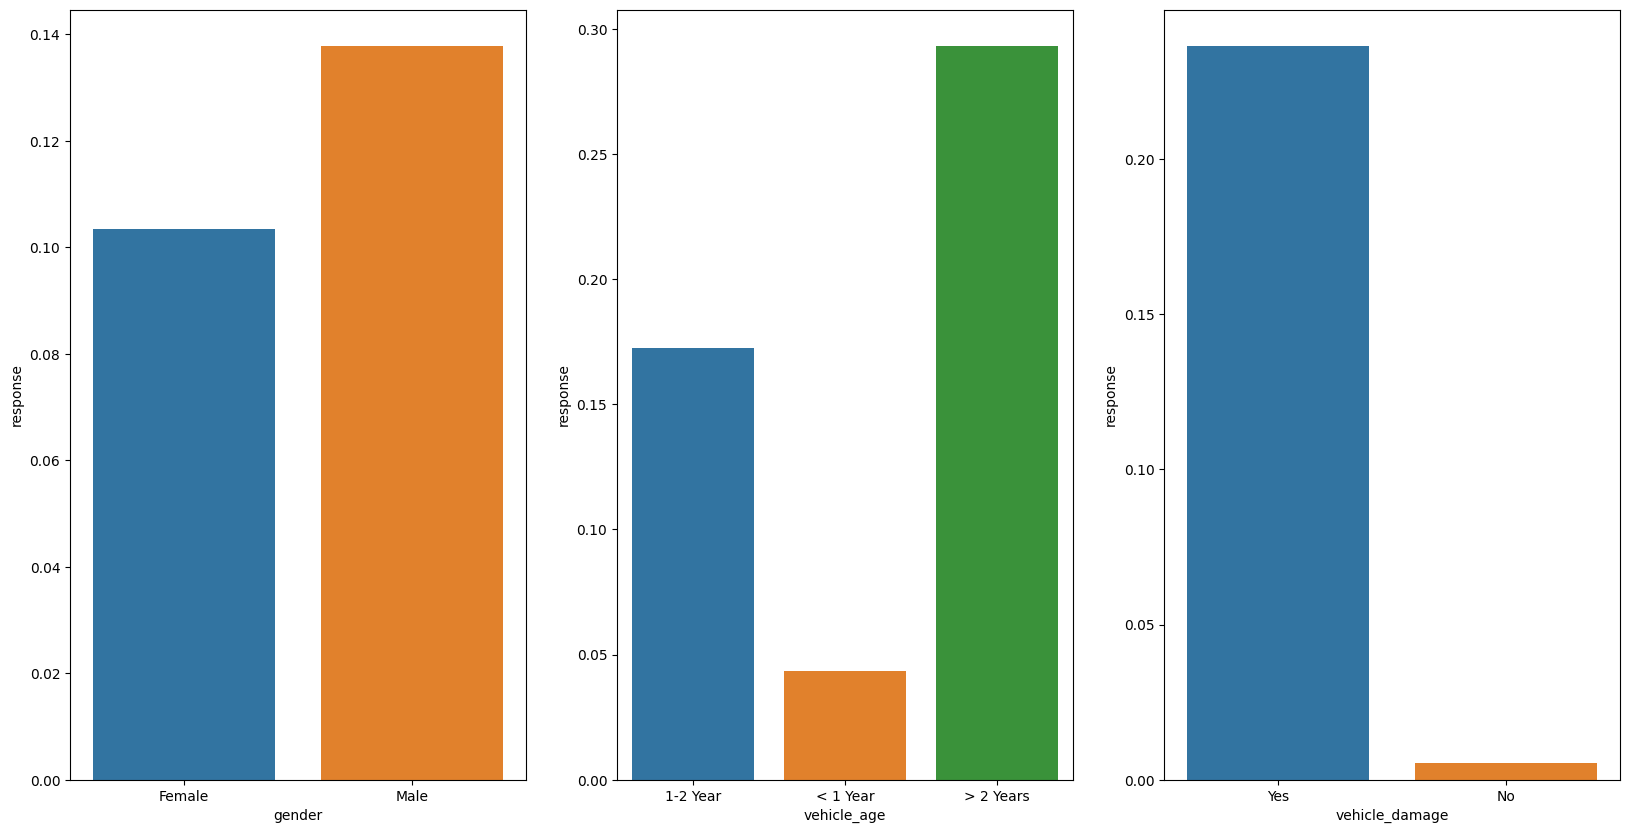

In [20]:

plt.figure(figsize=(20,10))

plt.subplot(1,3,1)
sns.barplot(x='gender', y='response', data=df1, errorbar=None)

plt.subplot(1,3,2)
sns.barplot(x='vehicle_age', y='response', data=df1, errorbar=None)

plt.subplot(1,3,3)
sns.barplot(x='vehicle_damage', y='response', data=df1, errorbar=None)


# 2.0 FEATURE ENGINEERING

## 2.1 Hypothesis

1. Pessoas que já possuem um seguro de saúde podem estar mais inclinadas a adquirir um seguro de veículo, pois já têm experiência com seguros.
2. Clientes que possuem um histórico de acidentes de carro podem estar mais interessados em um seguro de veículo.
3. Clientes que possuem um carro mais novo são mais prováveis de adquirirem o seguro.
4. A idade do cliente pode ser um fator importante, com os clientes mais jovens sendo menos propensos a adquirir um seguro de veículo.
5. A localização geográfica dos clientes pode ser um fator importante, com as pessoas que moram em áreas com altos índices de roubos de veículos sendo mais propensas a adquirir um seguro de veículo.
6. O gênero do cliente pode ser um fator, com homens sendo mais propensos a adquirir um seguro de veículo.
7. O preço do seguro de veículo pode ser um fator importante, com clientes mais propensos a adquirir um seguro de veículo se os preços estiverem competitivos.
8. Clientes com CNH são mais propensos a adquirirem o seguro.
9. Pessoas que já tinham seguros anteriormente tendem a querer o seguro, pois já têm experiência
10. Pessoas que são notificadas por algum meio específico(ex: telefone) podem tender a querer o seguro

## 2.2 Feature Engineering

In [21]:
df2 = df1.copy()

In [22]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,Female,39,1,15.0,0,1-2 Year,Yes,52906.0,55.0,227,1
116248,116249,Male,38,1,11.0,0,1-2 Year,Yes,23038.0,26.0,29,0
255005,255006,Male,22,1,30.0,1,< 1 Year,No,45318.0,152.0,166,0
317474,317475,Female,23,1,41.0,1,< 1 Year,No,29132.0,151.0,277,0
344212,344213,Male,56,1,48.0,0,> 2 Years,Yes,2630.0,154.0,155,0


In [23]:
df2 = rename_categorical(df2)

In [24]:
    df2.sample(15).T

,261558,196078,74250,52288,348377,312308,57684,99442,212973,303169,2963,158107,355616,326180,249557
id,261559,196079,74251,52289,348378,312309,57685,99443,212974,303170,2964,158108,355617,326181,249558
gender,0,1,0,1,1,1,0,0,1,1,0,0,0,1,0
age,22,58,23,24,48,47,45,22,26,25,48,22,38,24,27
driving_license,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
region_code,32.0,46.0,30.0,28.0,28.0,23.0,28.0,46.0,21.0,33.0,1.0,36.0,15.0,35.0,8.0
previously_insured,0,1,1,0,0,0,0,1,1,1,0,1,1,1,1
vehicle_age,new,used,new,new,used,used,used,new,new,new,used,new,used,new,new
vehicle_damage,1,0,0,1,1,1,1,0,0,0,1,0,0,0,0
annual_premium,29998.0,23835.0,26153.0,64157.0,39677.0,33069.0,39744.0,41401.0,20191.0,58152.0,2630.0,24667.0,2630.0,49599.0,27567.0
policy_sales_channel,152.0,30.0,152.0,152.0,124.0,26.0,124.0,152.0,152.0,152.0,124.0,152.0,152.0,152.0,152.0


# 3.0 VARIABLE FILTERING

In [25]:
df3 = df2.copy()

In [26]:
df3.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,0,39,1,15.0,0,used,1,52906.0,55.0,227,1
116248,116249,1,38,1,11.0,0,used,1,23038.0,26.0,29,0
255005,255006,1,22,1,30.0,1,new,0,45318.0,152.0,166,0
317474,317475,0,23,1,41.0,1,new,0,29132.0,151.0,277,0
344212,344213,1,56,1,48.0,0,old,1,2630.0,154.0,155,0


In [27]:
#df3 = df3.drop(columns=['id'])

# 4.0 EXPLORATORY DATA ANALYSIS

In [28]:
df4 = df3.copy()

In [29]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,0,39,1,15.0,0,used,1,52906.0,55.0,227,1
116248,116249,1,38,1,11.0,0,used,1,23038.0,26.0,29,0
255005,255006,1,22,1,30.0,1,new,0,45318.0,152.0,166,0
317474,317475,0,23,1,41.0,1,new,0,29132.0,151.0,277,0
344212,344213,1,56,1,48.0,0,old,1,2630.0,154.0,155,0


## 4.1 Unilateral Analysis

### 4.1.1 Numerical Variables

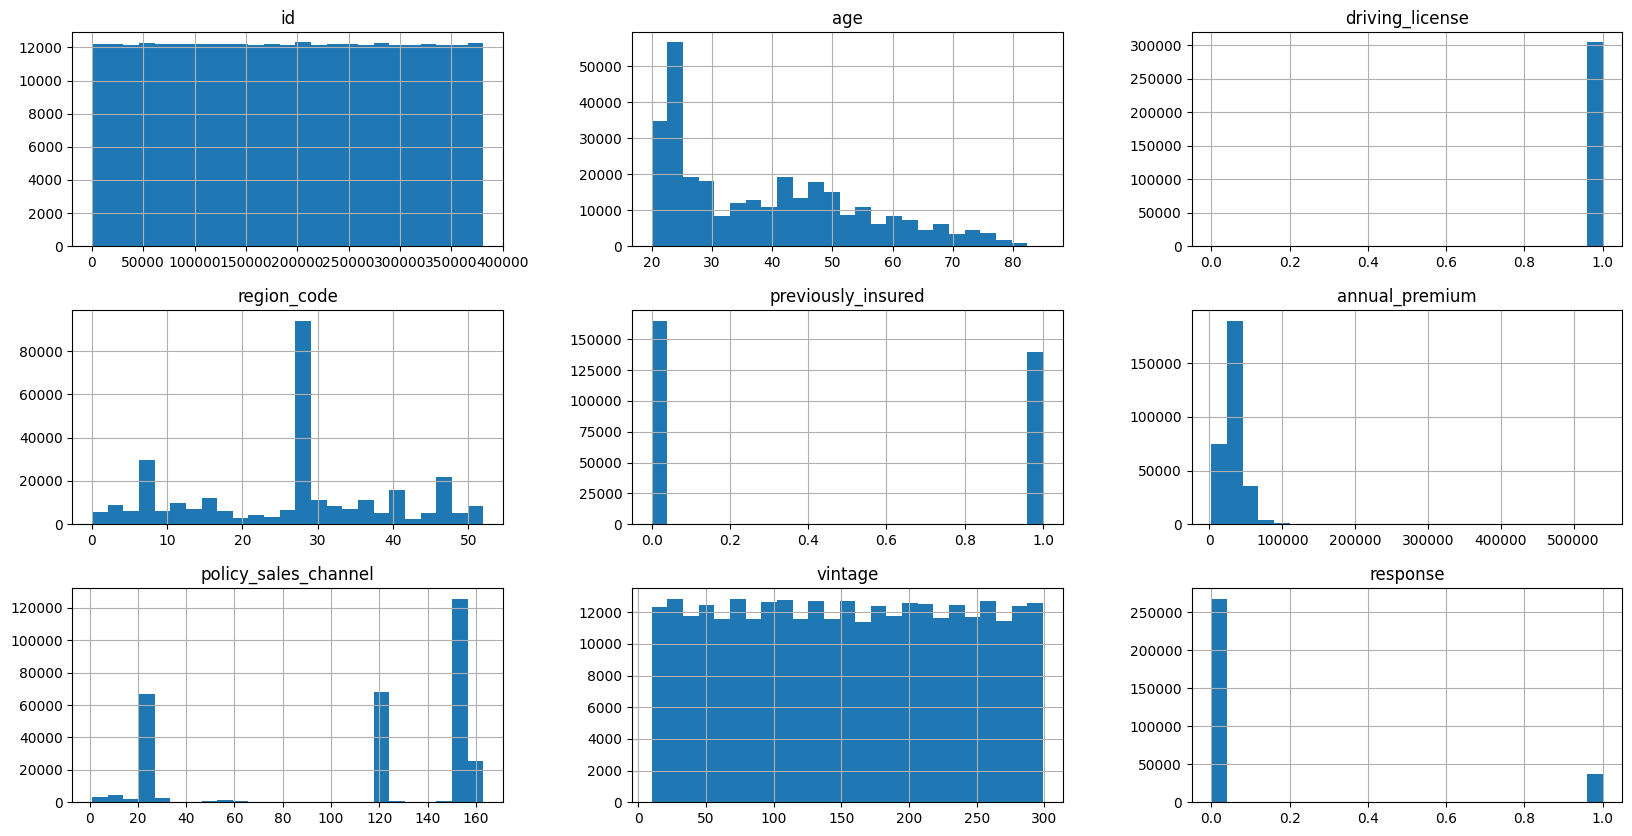

In [30]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
numerical_attributes.hist(ax = ax, bins=25);

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



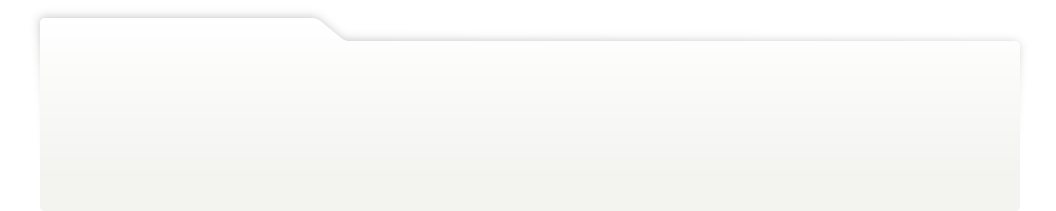
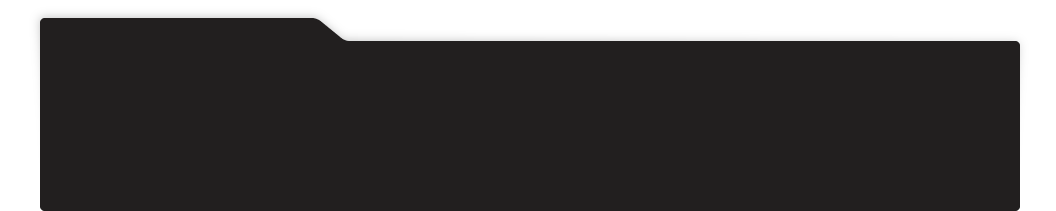
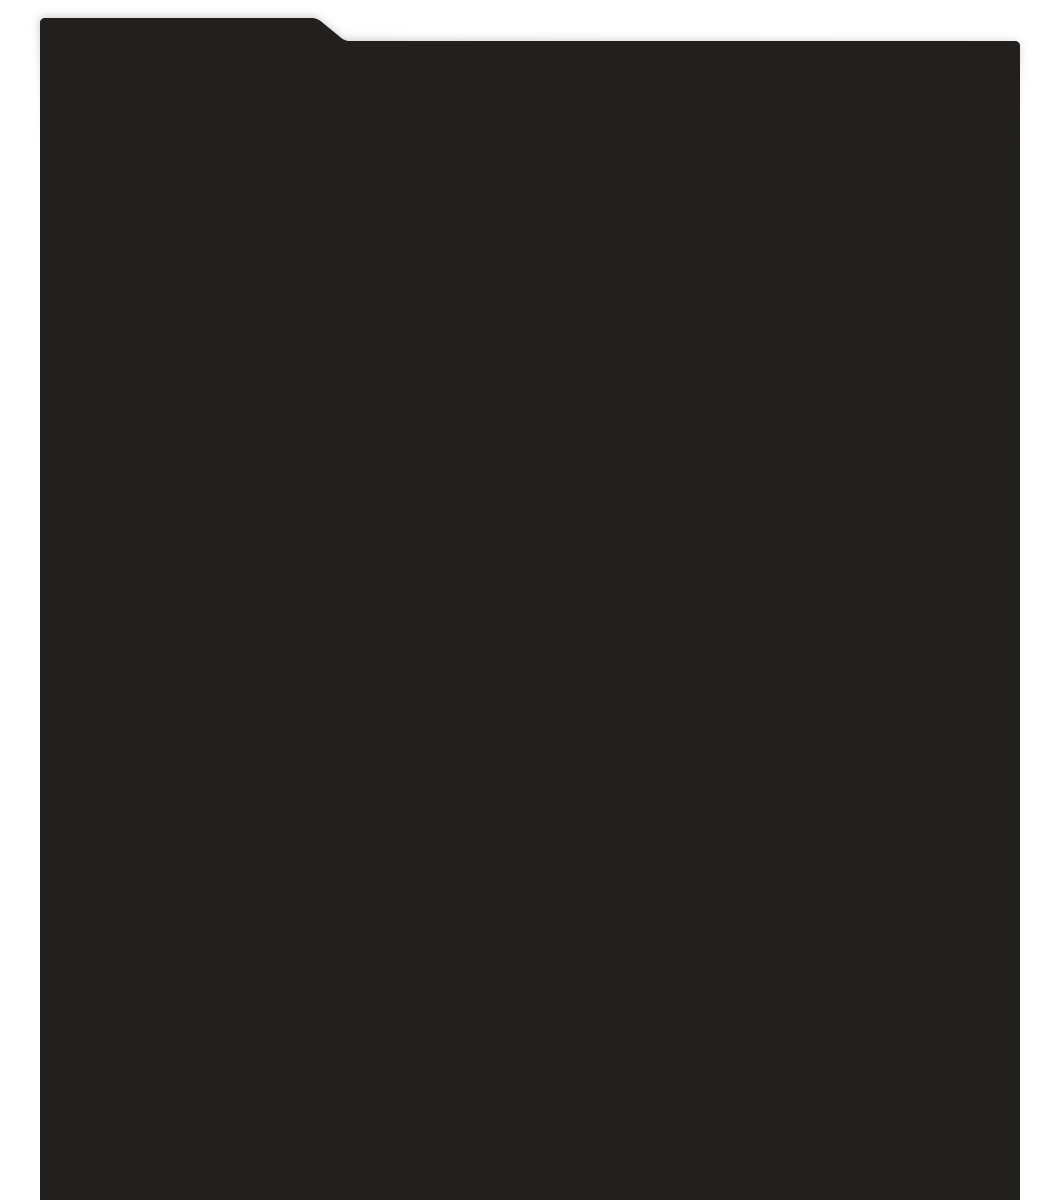
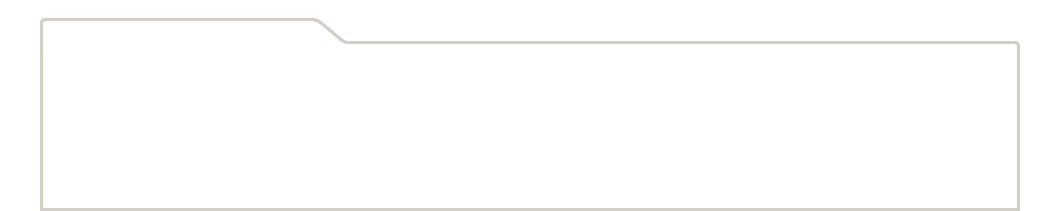
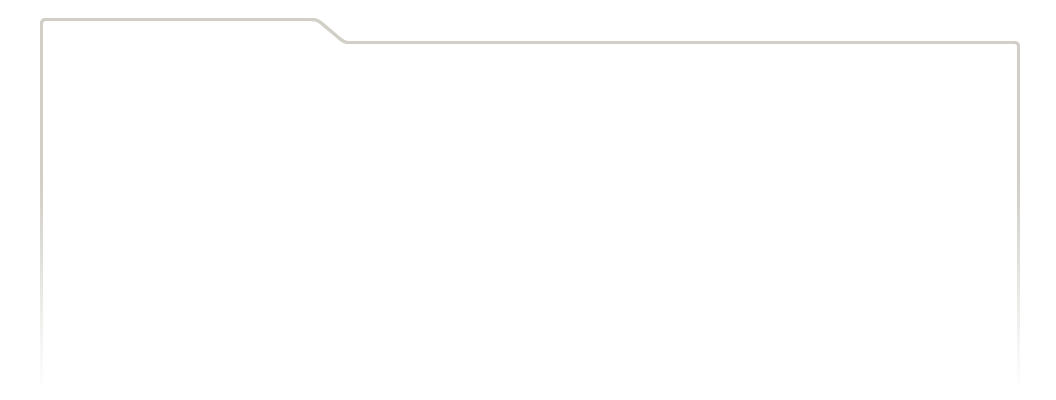
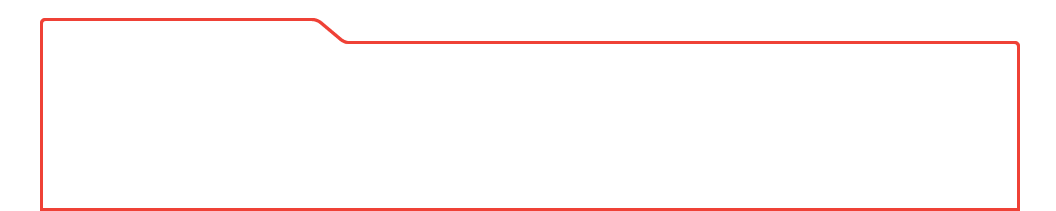
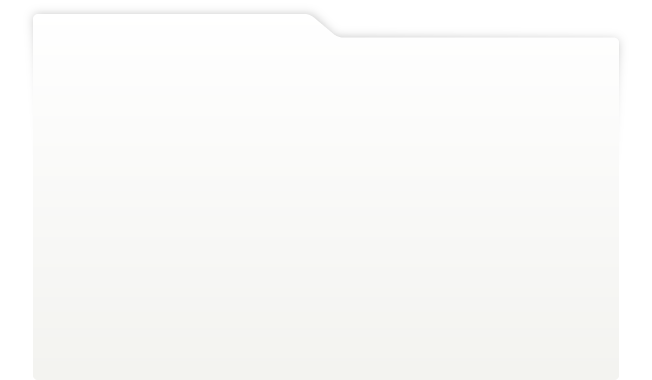
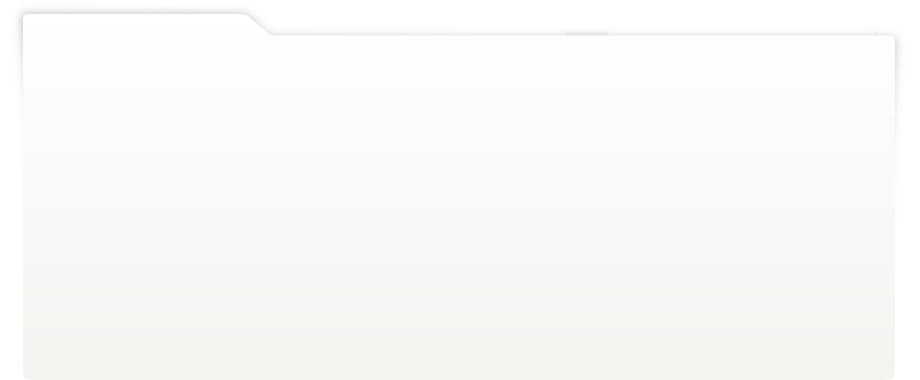
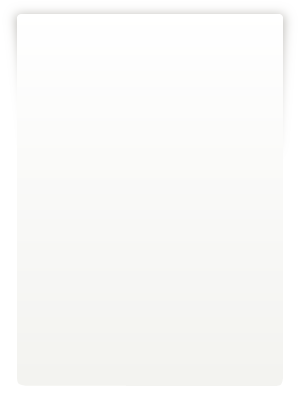
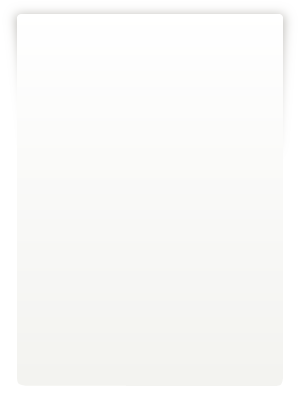
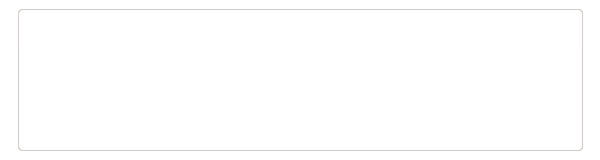
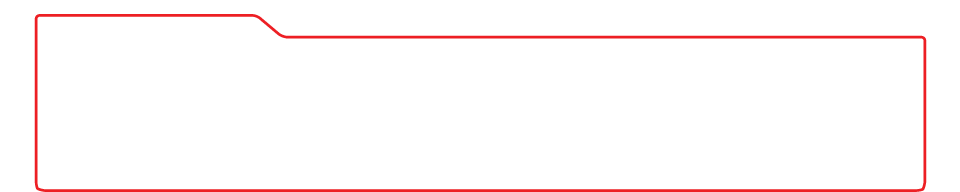
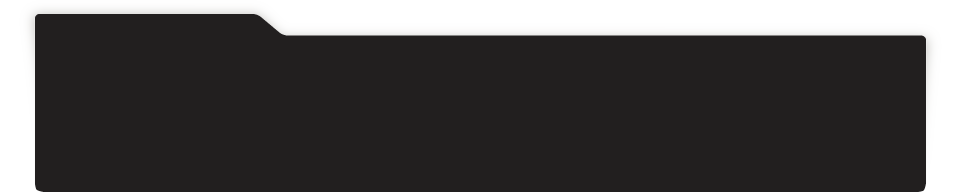
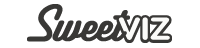
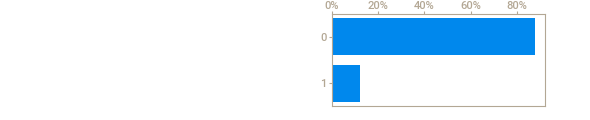
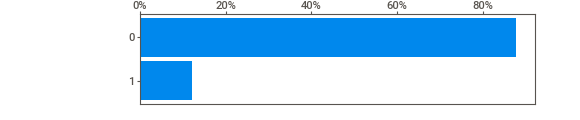
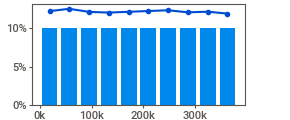
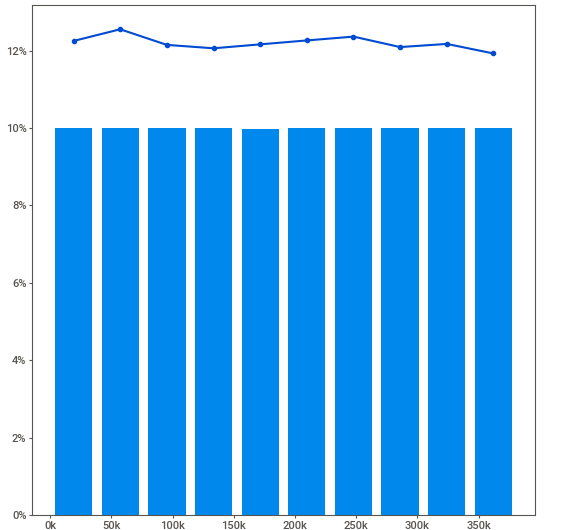
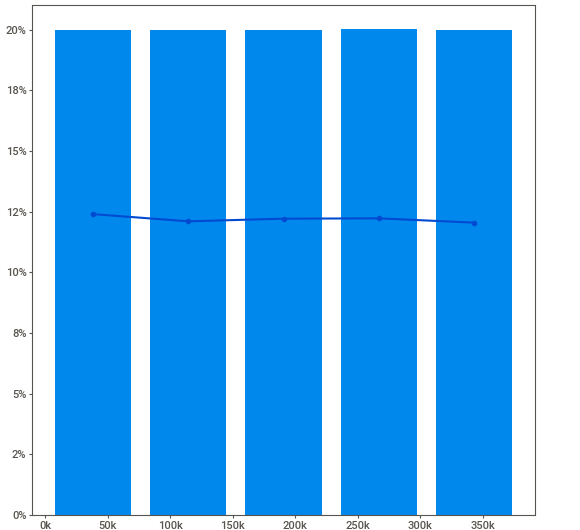
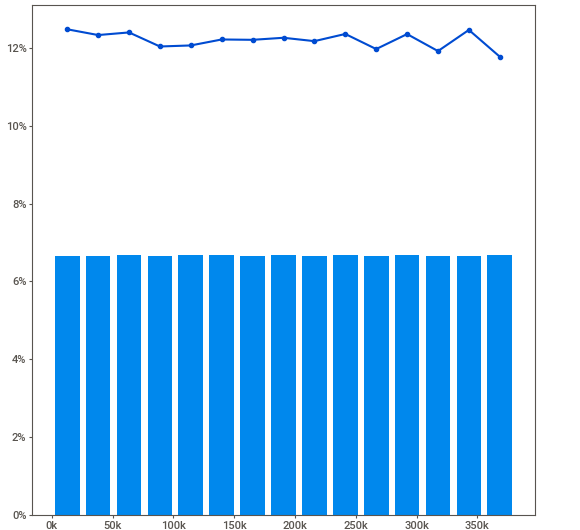
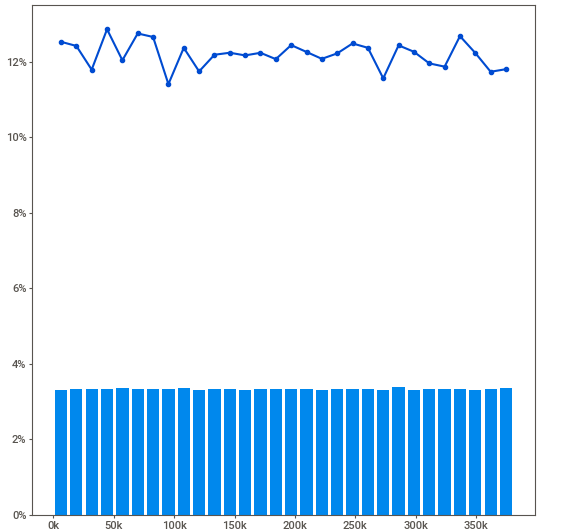
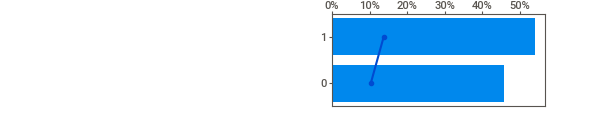
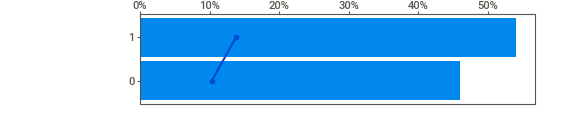
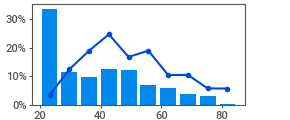
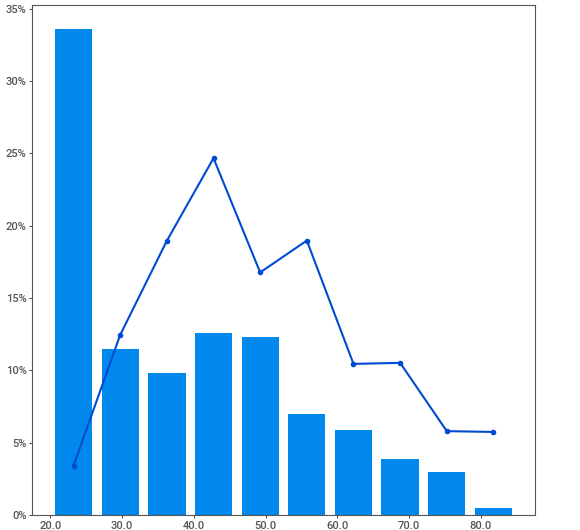
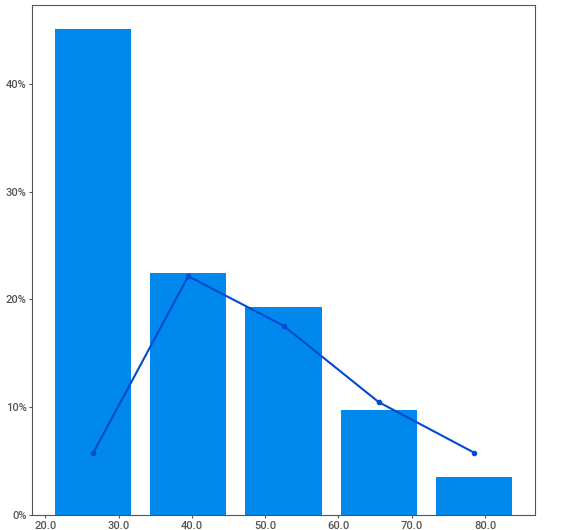
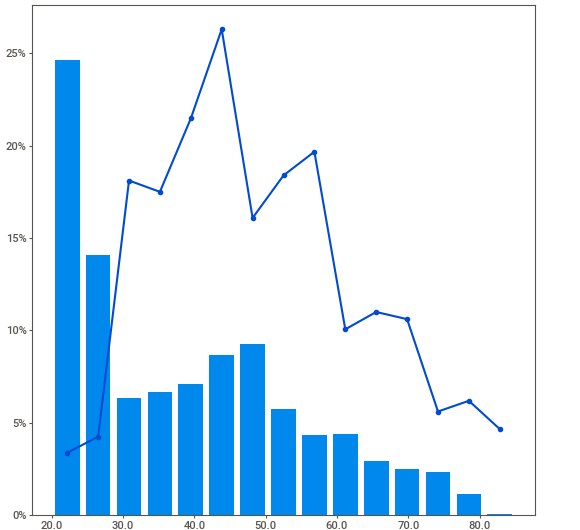
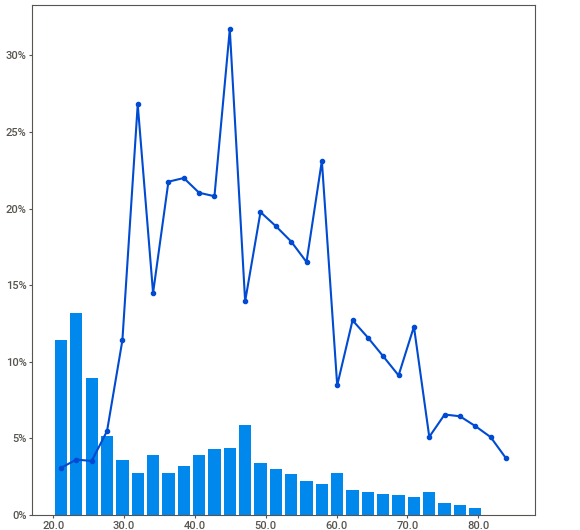
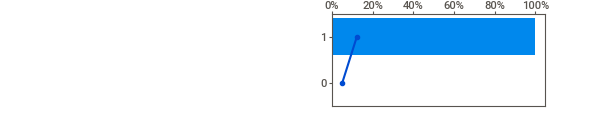
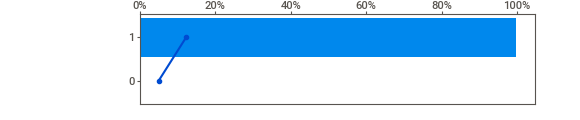
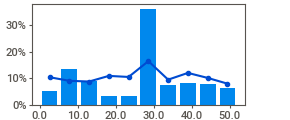
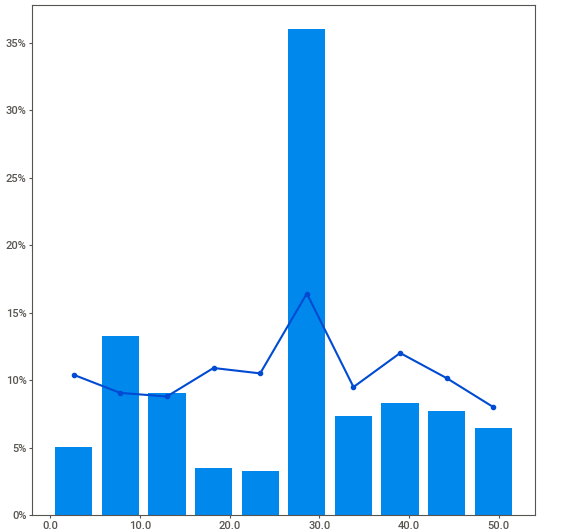
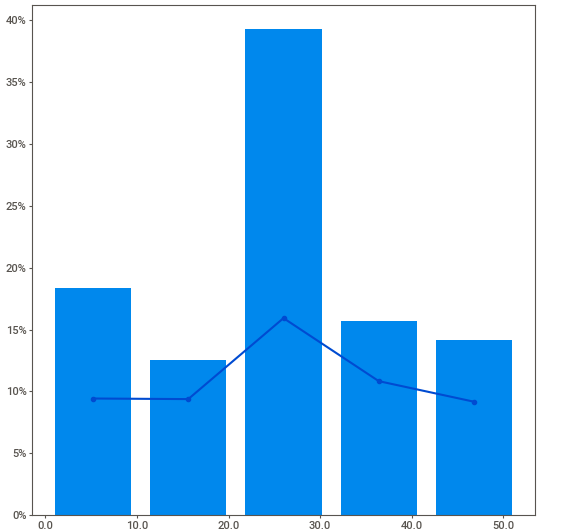
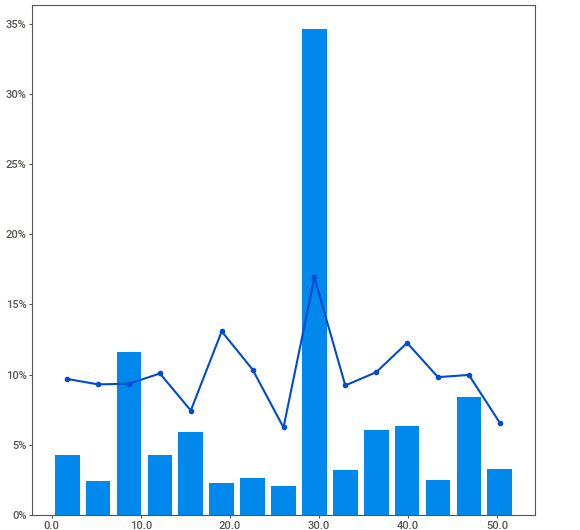
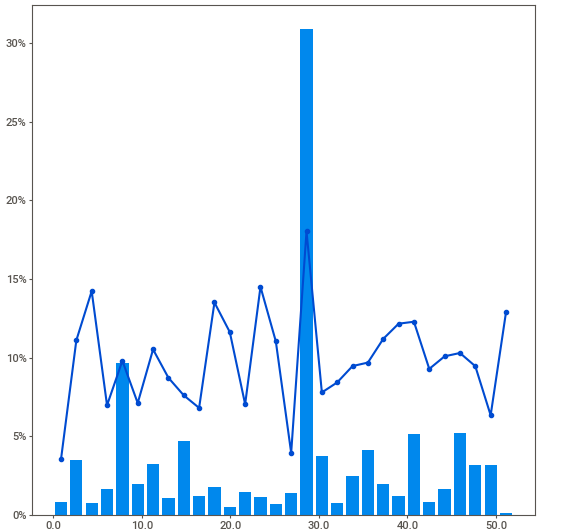
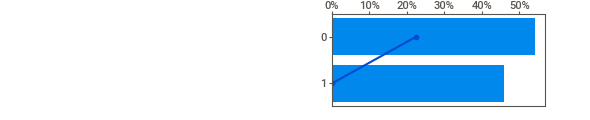
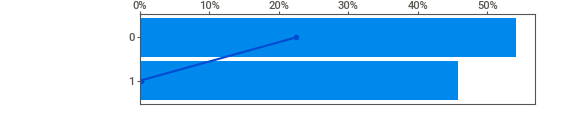
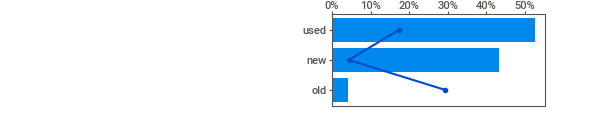
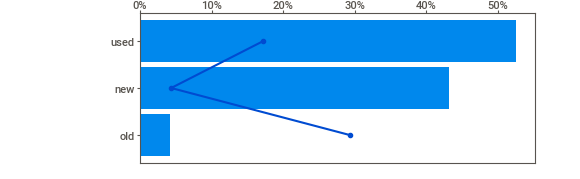
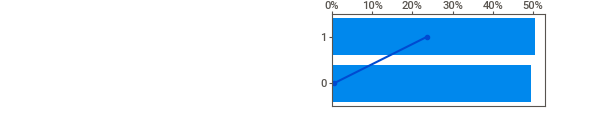
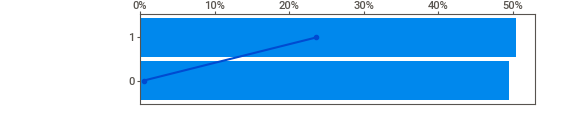
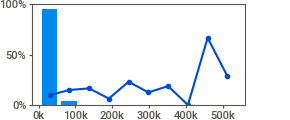
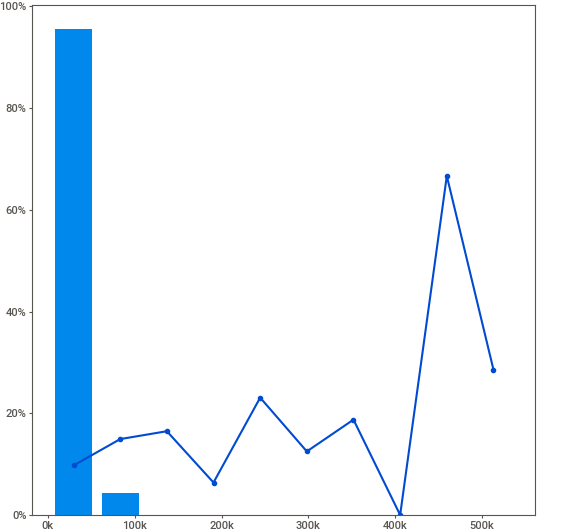
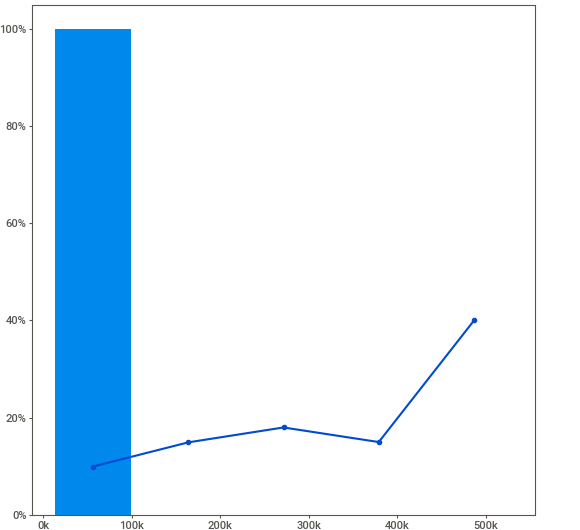
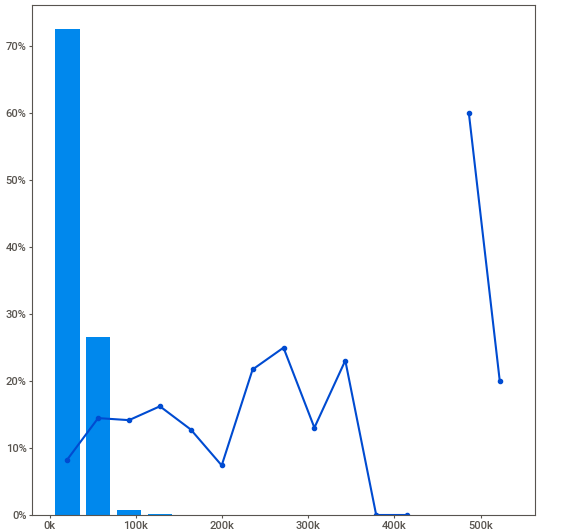
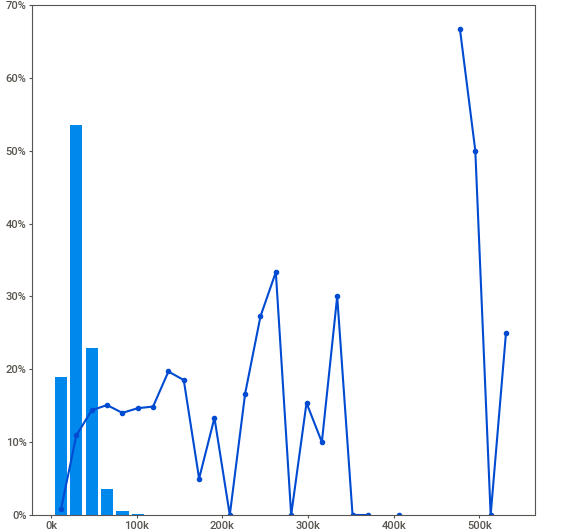
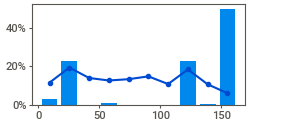
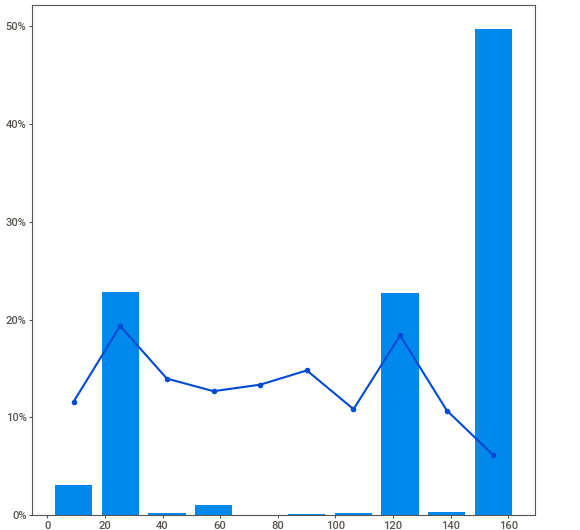
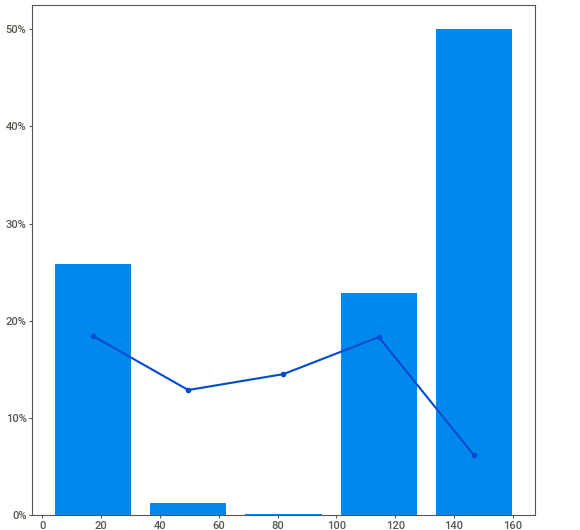
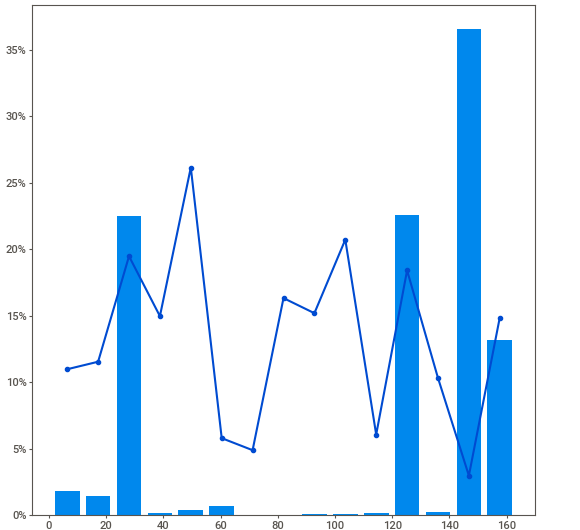
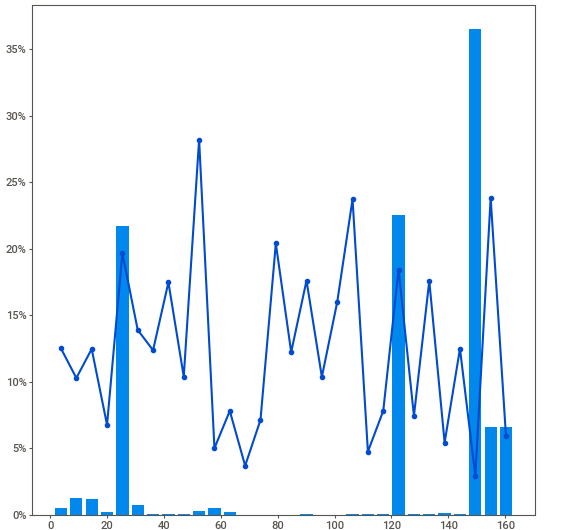
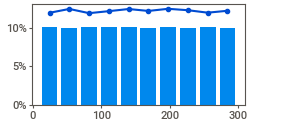
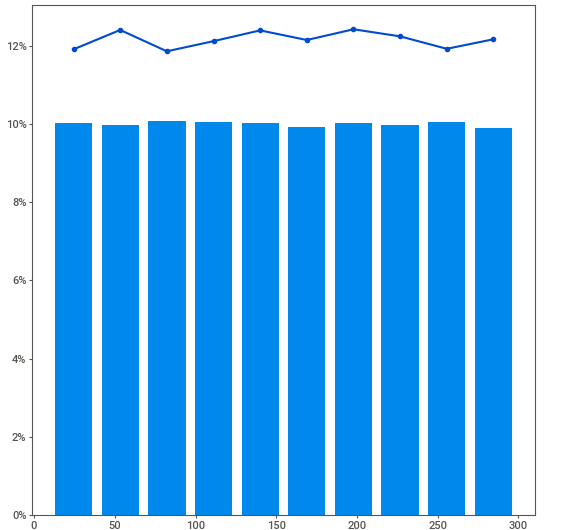
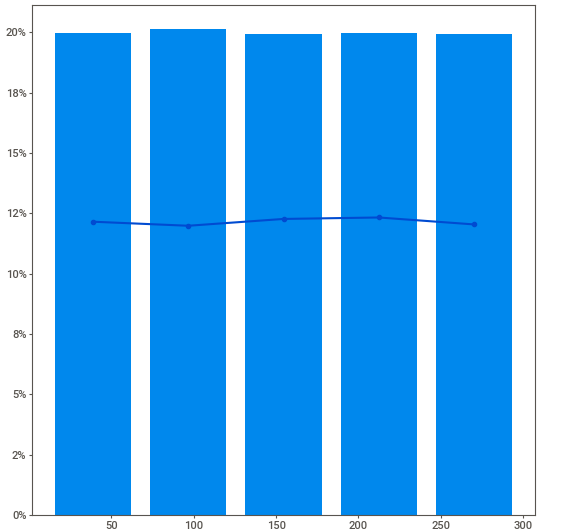
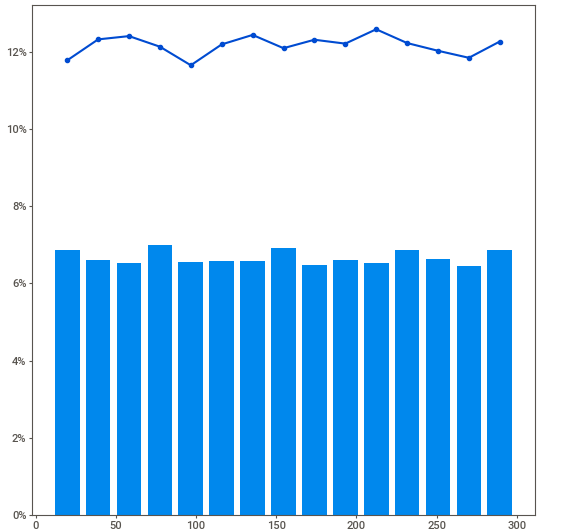
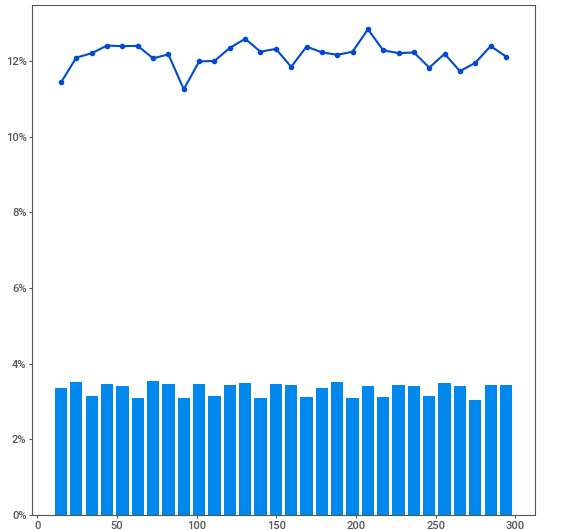
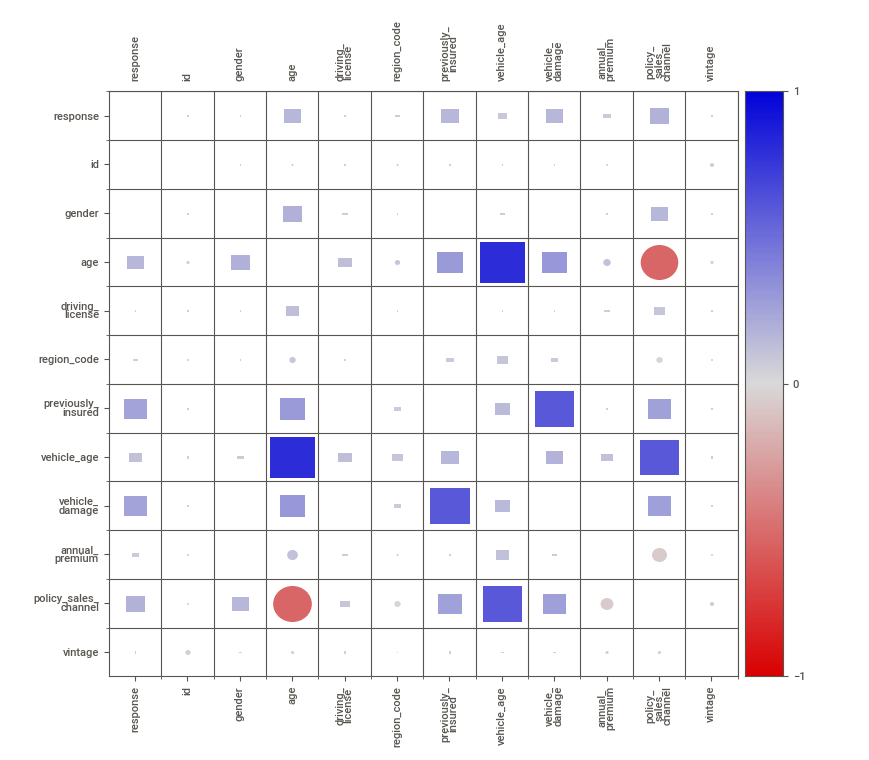
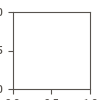

In [31]:
report = sv.analyze(source = df4, target_feat = 'response')

report.show_notebook(w="100%", h="full") # if working in Kaggle

### 4.1.2 Categorical Variables

In [32]:
categorical_attributes.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

<Axes: xlabel='vehicle_damage', ylabel='count'>

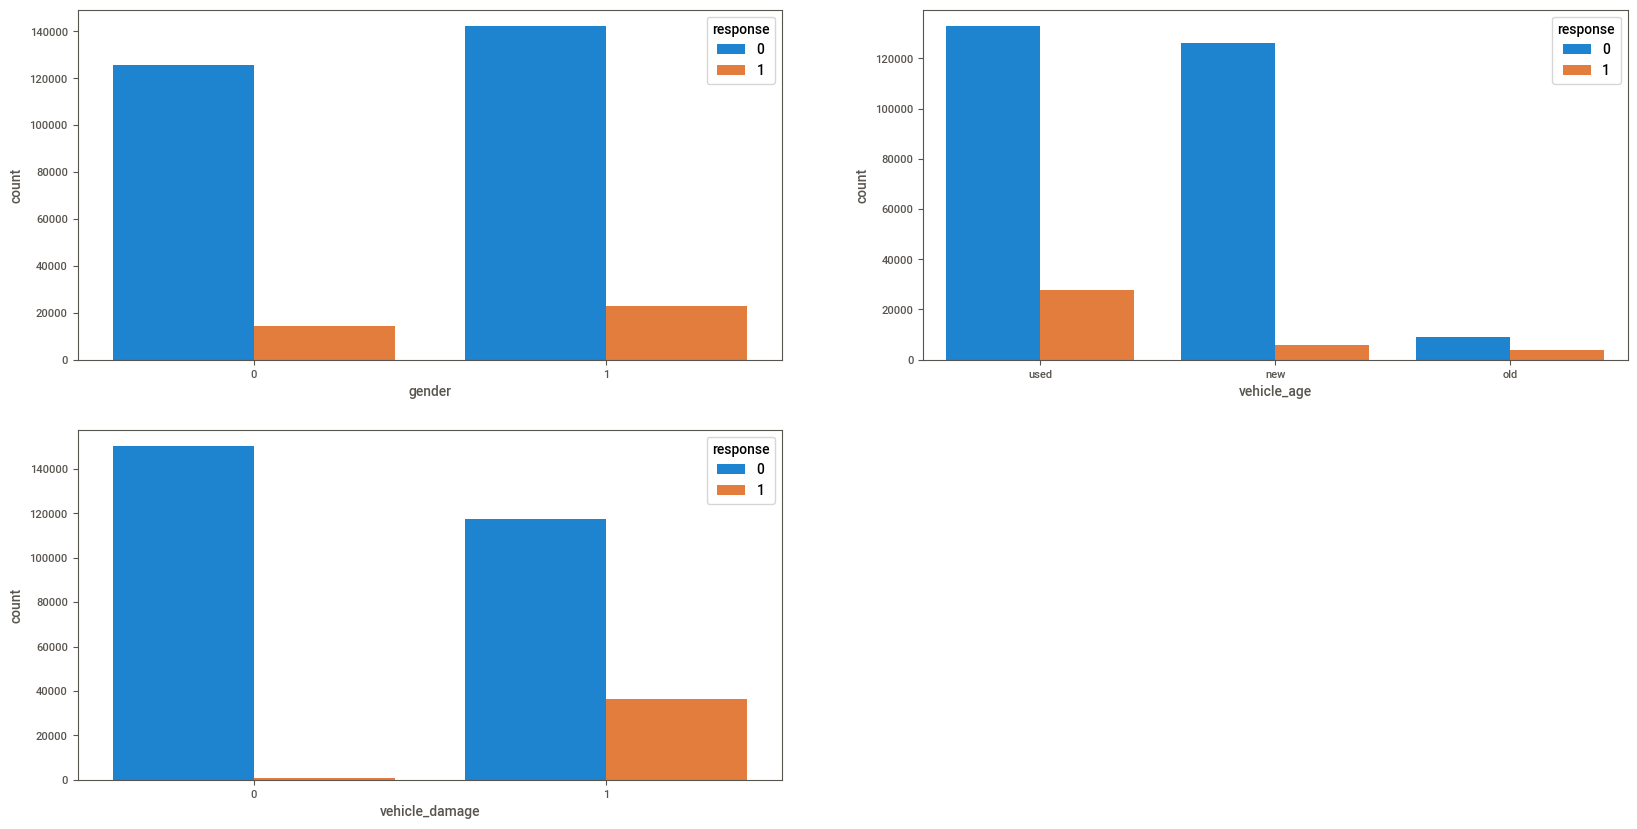

In [33]:
plt.figure(figsize=(20,10))

#gender
plt.subplot(2,2,1)
sns.countplot(data=df4, x='gender', hue='response')

#vehicle_age
plt.subplot(2,2,2)
sns.countplot(data=df4, x='vehicle_age', hue='response')

#vehicle_damage
plt.subplot(2,2,3)
sns.countplot(data=df4, x='vehicle_damage', hue='response')


## 4.2 Bilateral Analysis

### 4.2.1 H1 - Pessoas que já possuem um seguro de saúde podem estar mais inclinadas a adquirir um seguro de veículo, pois já têm experiência com seguros.

<Axes: xlabel='vintage', ylabel='Count'>

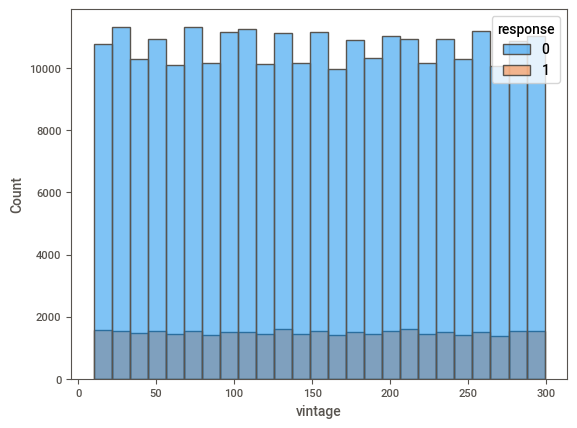

In [34]:
#Vintage
sns.histplot(x='vintage', hue='response', bins=25, data=df4)

 H1 - FALSO. Podemos ver que não há muita diferença nas barras laranjas se o cliente está com pouco dias <50 ou muito dias >250

### 4.2.2 H2 - Clientes que possuem um histórico de acidentes de carro podem estar mais interessados em um seguro de veículo.

<Axes: xlabel='vehicle_damage', ylabel='count'>

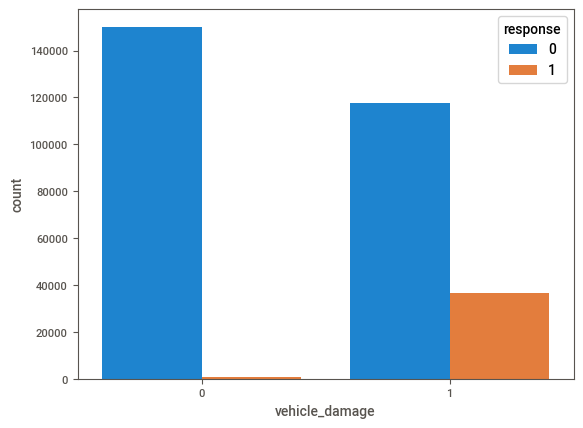

In [35]:
sns.countplot(data=df4, x='vehicle_damage', hue='response')

H2 - VERDADEIRO - Podemos ver que clientes que já tiveram defeito no carro no passado tendem a querer o seguro mais do que os que não tiveram

### 4.2.3 H3 - Clientes que possuem um carro mais novo são mais prováveis de adquirirem o seguro.

<Axes: xlabel='vehicle_age', ylabel='count'>

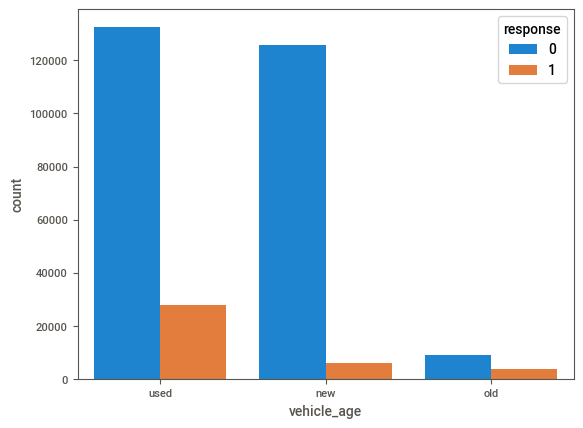

In [36]:
sns.countplot(data=df4, x='vehicle_age', hue='response')

H3 - FALSO - Clientes que possuem carros USADOS (entre 1 e 2 anos) são os que tendem a querer o seguro.

### 4.2.4 H4 - A idade do cliente pode ser um fator importante, com os clientes mais jovens sendo menos propensos a adquirir um seguro de veículo.

Text(0.5, 1.0, 'Idade Apenas dos que querem o seguro')

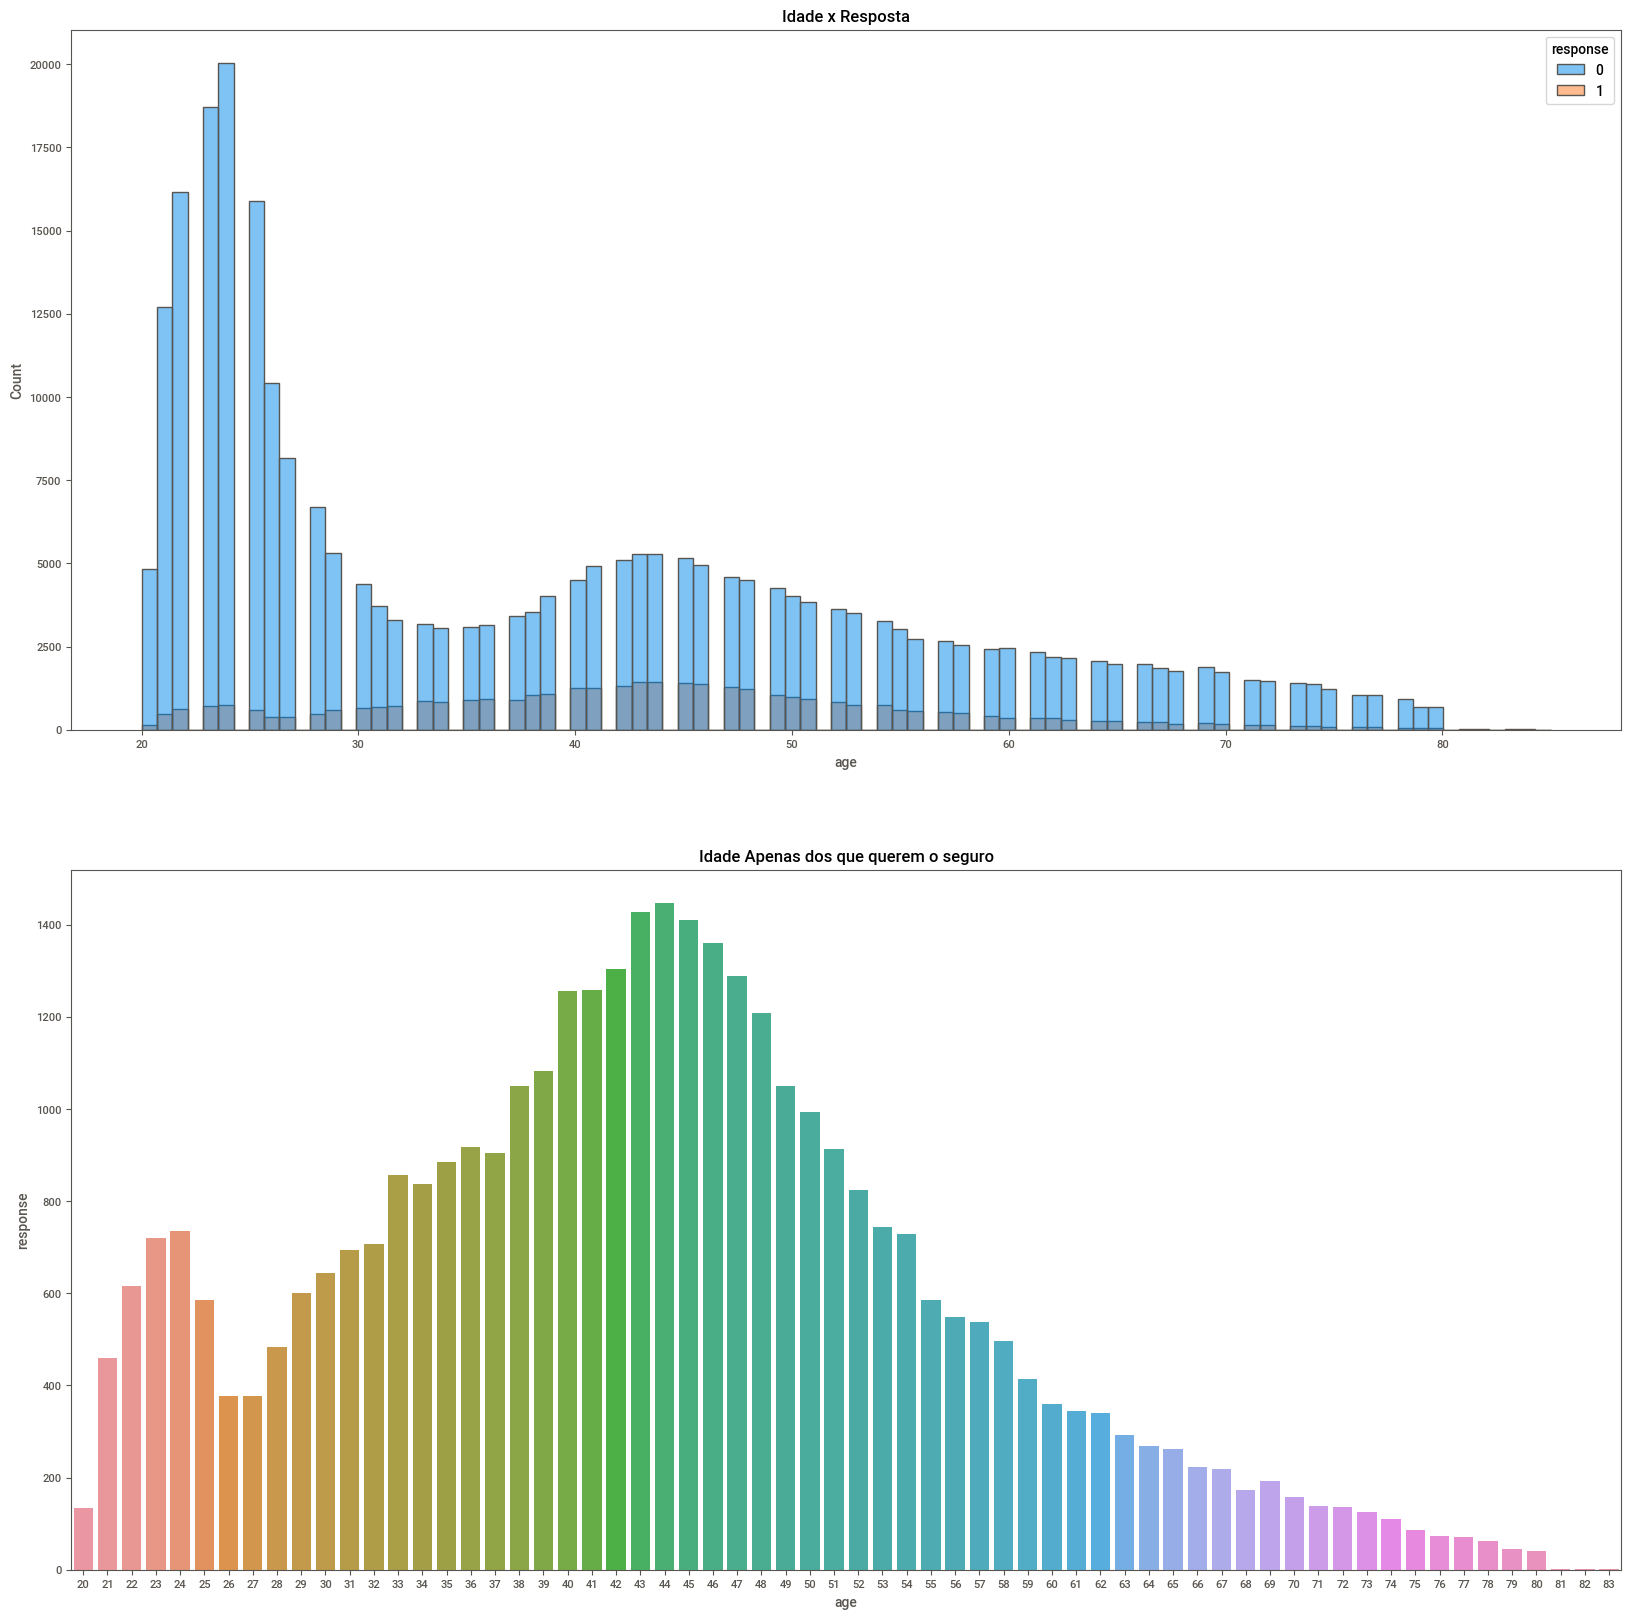

In [37]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
sns.histplot(x='age', hue='response', data=df4)
plt.title("Idade x Resposta")

plt.subplot(2,1,2)
aux = df4.loc[df4['response'] == 1,['response','age']].groupby('age').sum().reset_index()
sns.barplot(x='age', y='response', data=aux)
plt.title("Idade Apenas dos que querem o seguro")

H4 - VERDADEIRO - Os clientes entre a faixa de 40 e 50 são os mais propensos a adquirir o seguro

### 4.2.5 H5 - A localização geográfica dos clientes pode ser um fator importante, com as pessoas que moram em áreas com altos índices de roubos de veículos sendo mais propensas a adquirir um seguro de veículo.

<Axes: xlabel='region_code', ylabel='response'>

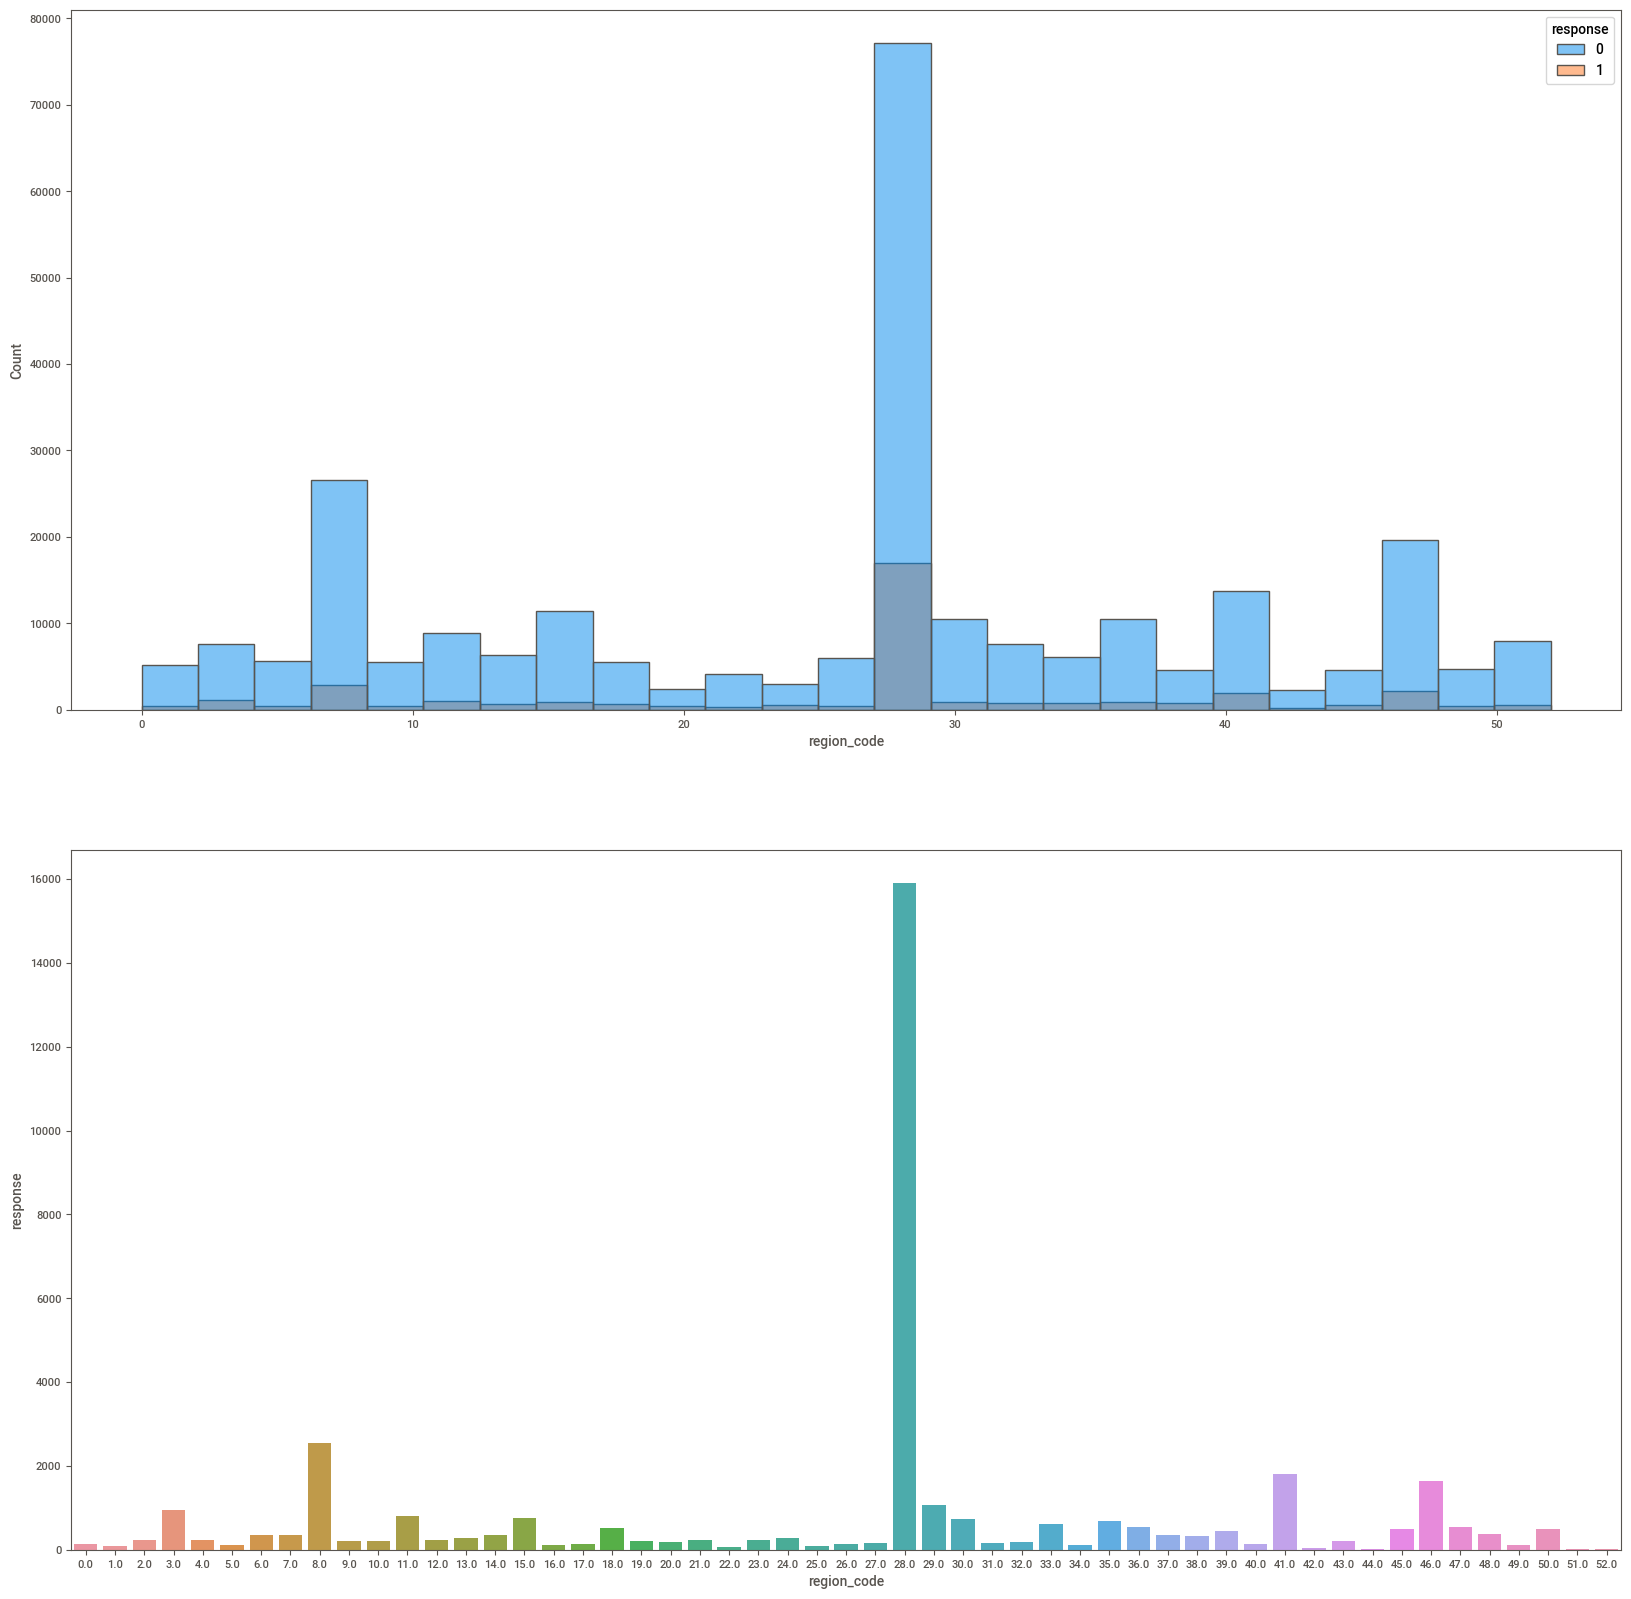

In [38]:
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
sns.histplot(x='region_code', hue='response', data=df4, bins=25)

plt.subplot(2,1,2)
aux = df4.loc[df4['response'] == 1,['response','region_code']].groupby('region_code').sum().reset_index()
sns.barplot(x='region_code', y='response', data=aux)

VERDADEIRO - Podemos ver que na região 028 temos muito mais clientes interessados em adquirir o seguro.

### 4.2.6 H6 - O gênero do cliente pode ser um fator, com homens sendo mais propensos a adquirir um seguro de veículo.

<Axes: xlabel='gender', ylabel='Count'>

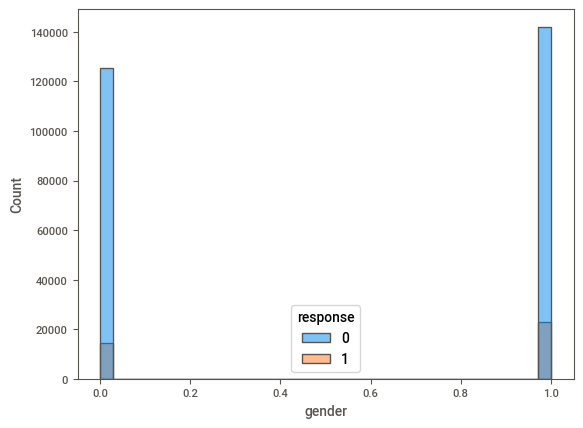

In [39]:
sns.histplot(x='gender', hue='response', data=df4)

VERDADEIRO - Podemos ver pelas barras laranjas que, dos que têm interesse no seguro, a maioria são homens.

### 4.2.7 H7 - O preço do seguro de veículo pode ser um fator importante, com clientes mais propensos a adquirir um seguro de veículo se os preços estiverem competitivos.

<Axes: xlabel='annual_premium', ylabel='Count'>

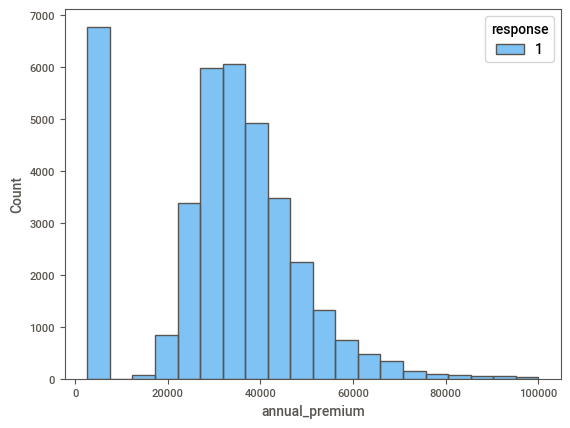

In [40]:
aux1 = df4.loc[(df4['response'] == 1) & (df4['annual_premium'] < 100000),['annual_premium','response']]
sns.histplot(x='annual_premium', hue='response', data=aux1, bins=20)

VERDADEIRO - A maioria dos clientes que gostariam de adquirir o seguro seria no valor de 2630. Depois o pico aparece em torno dos 40.000. Provavelmente esse seguro de 2630 seja o mais barato com algumas vantagens e depois o de 40.000 ofereça vantagens mais robustas.

### 4.2.8 H8 - Clientes com CNH são mais propensos a adquirirem o seguro.

<Axes: xlabel='driving_license', ylabel='Count'>

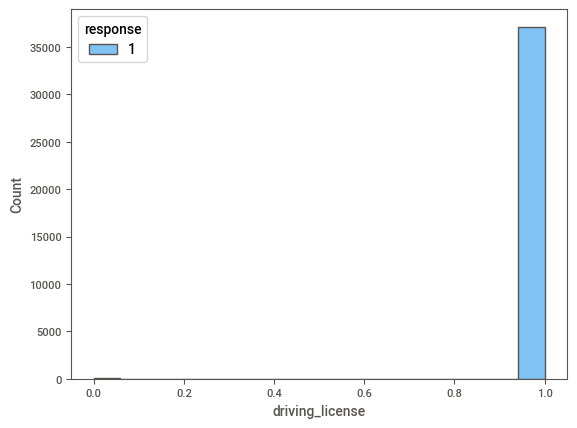

In [41]:
aux1 = df4.loc[df4['response'] == 1,['driving_license','response']]
sns.histplot(x='driving_license', hue='response', data=aux1)

VERDADEIRO - A maioria dos clientes que querem o seguro possuem CNH.

### 4.2.9 - H9 - Pessoas que já tinham seguros anteriormente tendem a querer o seguro, pois já têm experiência.

<Axes: xlabel='previously_insured', ylabel='Count'>

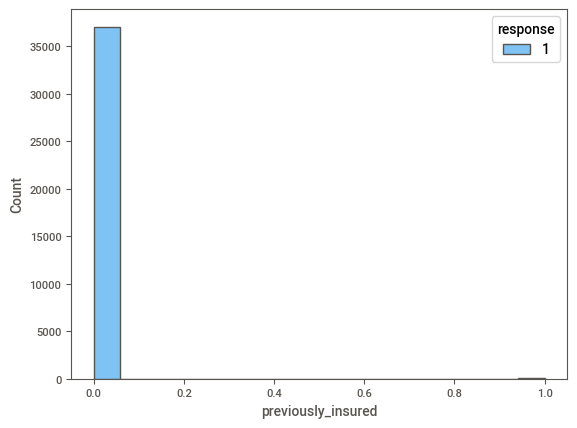

In [42]:
aux1 = df4.loc[(df4['response'] == 1),['previously_insured','response']]
sns.histplot(x='previously_insured', hue='response', data=aux1)

FALSO - Praticamente todas as pessoas que já tinham seguro anteriormente não querem o novo seguro.

### 4.2.10 - H10 - Pessoas que são notificadas por algum meio específico(ex: telefone) podem tender a querer o seguro

<Axes: xlabel='policy_sales_channel', ylabel='Count'>

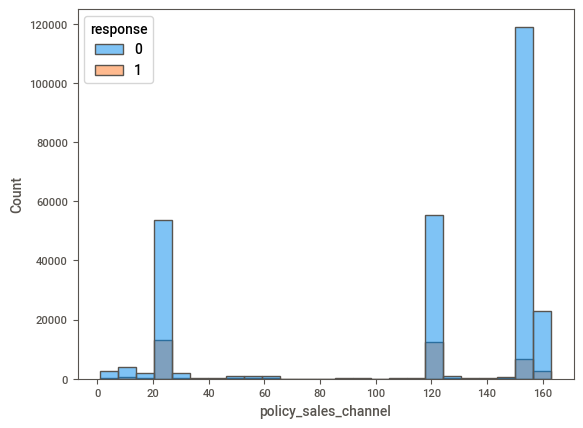

In [43]:
sns.histplot(x='policy_sales_channel', hue='response', data=df4, bins=25)

VERDADEIRO - Existem forma de contato com o cliente que facilitam eles a adquirirem o seguro.

## 4.3 Multilateral Analysis

<Axes: >

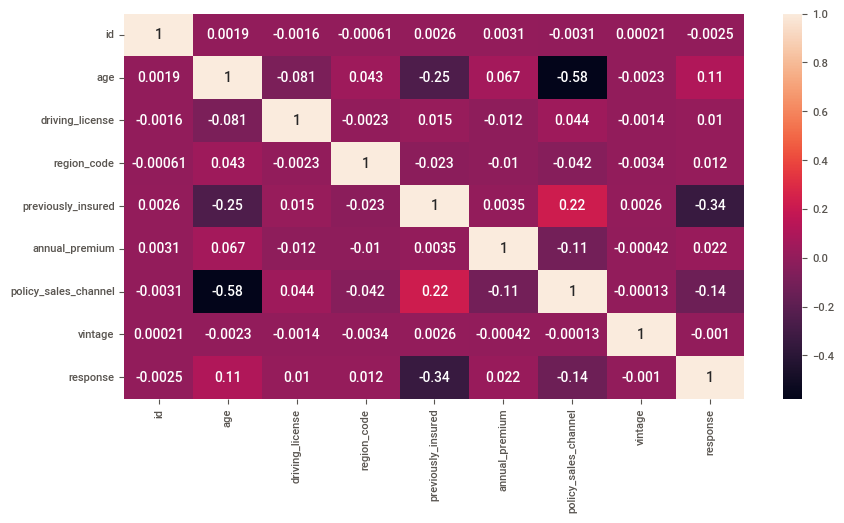

In [44]:
#Correlation Numerical Variables
plt.figure(figsize=(10,5))
sns.heatmap(numerical_attributes.corr(method='pearson'), annot=True)

In [45]:
a = categorical_attributes

<Axes: >

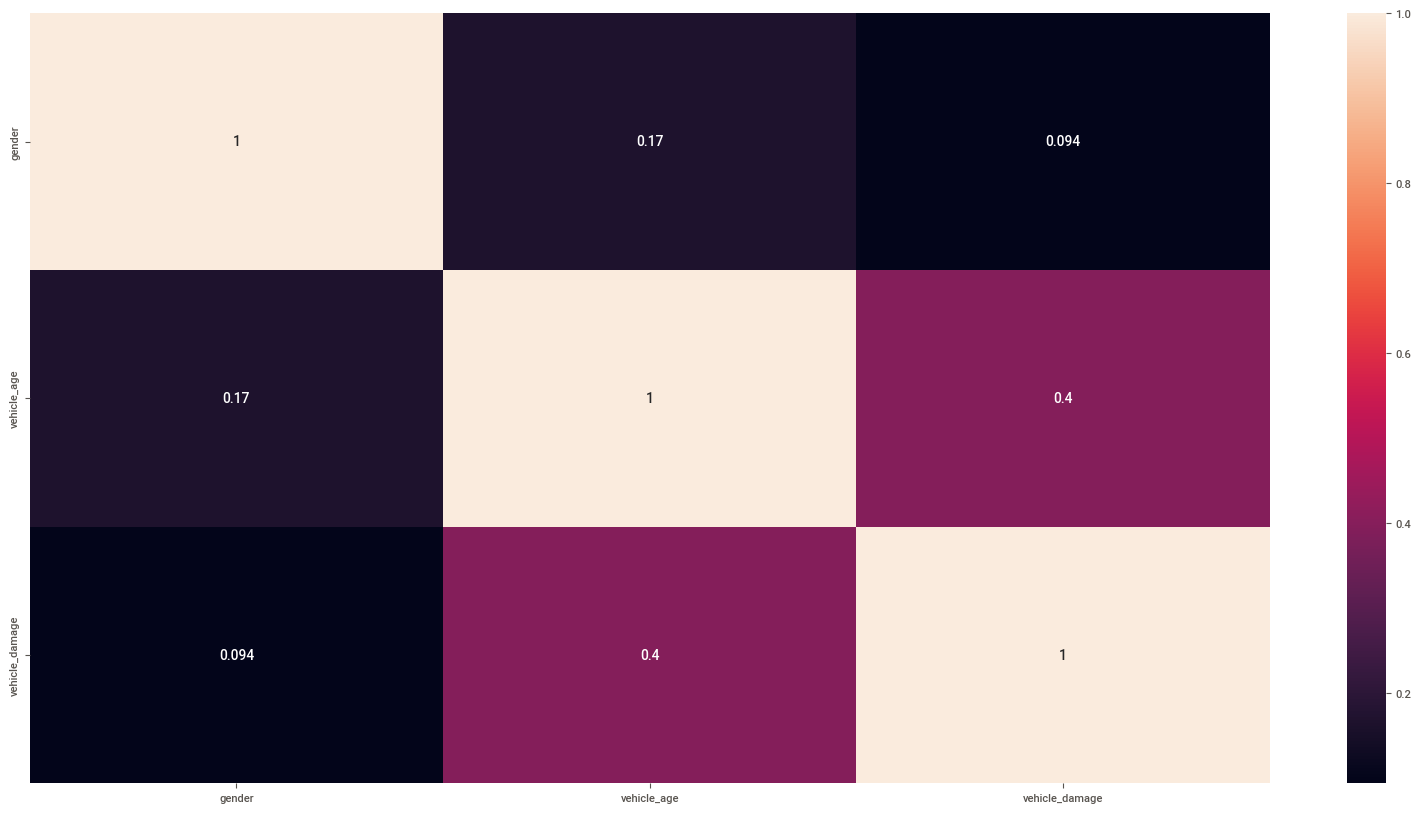

In [46]:
#Correlation Categorical Variables
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )
a3 = cramer_v( a['gender'], a['vehicle_damage'] )

a4 = cramer_v( a['vehicle_age'], a['gender'] )
a5 = cramer_v( a['vehicle_age'], a['vehicle_age'] )
a6 = cramer_v( a['vehicle_age'], a['vehicle_damage'] )

a7 = cramer_v( a['vehicle_damage'], a['gender'] )
a8 = cramer_v( a['vehicle_damage'], a['vehicle_age'] )
a9 = cramer_v( a['vehicle_damage'], a['vehicle_damage'] )

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3], 
               'vehicle_age': [a4, a5, a6],
               'vehicle_damage': [a7, a8, a9]  })
d = d.set_index( d.columns )
plt.figure(figsize=(20,10))
sns.heatmap( d, annot=True )

# 5.0 DATA PREPARATION

In [47]:
df5 = df4.copy()

In [48]:
df5.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
332803,332804,0,39,1,15.0,0,used,1,52906.0,55.0,227,1
116248,116249,1,38,1,11.0,0,used,1,23038.0,26.0,29,0
255005,255006,1,22,1,30.0,1,new,0,45318.0,152.0,166,0
317474,317475,0,23,1,41.0,1,new,0,29132.0,151.0,277,0
344212,344213,1,56,1,48.0,0,old,1,2630.0,154.0,155,0


## 5.1 Encoding

In [49]:
df5 = data_encoding(df5)

## 5.2 Rescalling

In [50]:
df5 = data_rescalling(df5)

## 5.3 Validation Preparation

In [51]:
# #vehicle_age - Label Encoder
# X_val['vehicle_age'] = X_val['vehicle_age'].apply(lambda x: 0 if x == 'new' else 1 if x == 'used' else 2)

# #gender - Target(mean) Enconding
# #target_encoder_gender = X_val.loc[:,['gender','response']].groupby('gender').mean().reset_index()
# #df5['gender'] = X_val['gender'].apply(lambda x: target_encoder_gender.iloc[0,1] if x == 0 else target_encoder_gender.iloc[1,1] )

# #region_code - Frequency Encoding
# X_val['region_code'] = X_val['region_code'].map(fe_region_code)


# #policy_sales_channel
# X_val['policy_sales_channel'] = X_val['policy_sales_channel'].map(fe_policy_sales_channel)

# #age 
# X_val['age'] = mms.fit_transform(X_val['age'].values.reshape(-1,1))

# #annual_premium
# X_val['annual_premium'] = rb.fit_transform(X_val['annual_premium'].values.reshape(-1,1))

# #vintage
# X_val['vintage'] = mms.fit_transform(X_val['vintage'].values.reshape(-1,1))

# X_val = X_val.fillna(0)

## 5.4 Split Dataframe into Training and Validation

In [52]:
X = df5.drop('response', axis=1)
y = df5['response']

X_train, X_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.2, random_state=42)

df5 = pd.concat([X_train, y_train],axis=1)

In [53]:
#keep ID for precision K
x_validation = X_val
x_validation['response'] = y_val

# 6.0 FEATURE SELECTION

In [54]:
df6 = df5.copy()

In [55]:
df6.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
217927,217928,0,0.276923,1,0.019511,1,1,0,0.070490,0.353663,0.224913,0
54207,54208,1,0.015385,1,0.051820,1,0,0,-0.082694,0.057146,0.391003,0
18364,18365,1,0.707692,1,0.279225,0,1,1,1.549583,0.015725,0.041522,0
195540,195541,0,0.323077,1,0.279225,1,1,0,2.271957,0.209127,0.865052,0
30463,30464,1,0.461538,1,0.034919,0,1,1,0.502568,0.209127,0.730104,0


## 6.1 Boruta

In [56]:
rf = RandomForestRegressor(n_jobs=-1)

In [57]:
X = df6.drop('response', axis=1)
y = df6['response']

X_train_n, X_test_n, y_train_n, y_test_n = ms.train_test_split(X, y, test_size=0.2, random_state=42)
X_train_nn = X_train_n.values
y_train_nn = y_train_n.ravel()
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_nn, y_train_nn)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0


KeyboardInterrupt: 

In [ ]:
cols_boruta = boruta.support_.tolist()

## 6.2 ExtraTree

In [58]:
#model
forest = ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

#data preparation
x_train_n = X_train.drop(['id'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

In [59]:
importances = forest.feature_importances_
features = {}

for i in range(len(x_train_n.columns)):
    features[x_train_n.columns[i]] = importances[i]
    
features = pd.DataFrame(features, index=[0])    
features = features.melt(var_name='Features', value_name='Ranking')
features.sort_values(ascending=False, by='Ranking')

,Features,Ranking
9,vintage,0.277232
7,annual_premium,0.245532
1,age,0.165729
3,region_code,0.098681
6,vehicle_damage,0.074086
8,policy_sales_channel,0.061954
4,previously_insured,0.054107
5,vehicle_age,0.016605
0,gender,0.005574
2,driving_license,0.000501


## 6.3 RandomForest

In [60]:
#model
forest = RandomForestClassifier(n_estimators=250, random_state=0, n_jobs=-1)

#data preparation
x_train_n = X_train.drop(['id'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=0)

In [61]:
importances = forest.feature_importances_
features = {}

for i in range(len(x_train_n.columns)):
    features[x_train_n.columns[i]] = importances[i]
    
features = pd.DataFrame(features, index=[0])    
features = features.melt(var_name='Features', value_name='Ranking')
features.sort_values(ascending=False, by='Ranking')

,Features,Ranking
9,vintage,0.278909
7,annual_premium,0.249897
1,age,0.147277
3,region_code,0.100000
6,vehicle_damage,0.069536
8,policy_sales_channel,0.069099
4,previously_insured,0.053887
5,vehicle_age,0.017746
0,gender,0.013082
2,driving_license,0.000567


In [62]:
cols_selected = {'vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured','vehicle_age','gender'}

# 7.0 Machine Learning

In [63]:
df7 = df6.copy()

In [64]:
df7.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
217927,217928,0,0.276923,1,0.019511,1,1,0,0.070490,0.353663,0.224913,0
54207,54208,1,0.015385,1,0.051820,1,0,0,-0.082694,0.057146,0.391003,0
18364,18365,1,0.707692,1,0.279225,0,1,1,1.549583,0.015725,0.041522,0
195540,195541,0,0.323077,1,0.279225,1,1,0,2.271957,0.209127,0.865052,0
30463,30464,1,0.461538,1,0.034919,0,1,1,0.502568,0.209127,0.730104,0


In [65]:
X_train = X_train.loc[:,cols_selected]
X_val = X_val.loc[:,cols_selected]

## Compare Models

In [66]:
model_list = [  DummyClassifier(),
                LogisticRegression(),
                DecisionTreeClassifier(),
                KNeighborsClassifier(),
                GaussianNB(),
                RandomForestClassifier(),
                XGBClassifier(),
                lgb.LGBMClassifier()]
    

In [67]:
for model in model_list:
    model.fit(X_train, y_train)
    yhat = model.predict_proba(X_val)
    print(f"{model} Acurácia Top K: {mt.top_k_accuracy_score(y_val, yhat[:,1], k=1):.3f}%")

DummyClassifier() Acurácia Top K: 0.877%
LogisticRegression() Acurácia Top K: 0.877%
DecisionTreeClassifier() Acurácia Top K: 0.823%
KNeighborsClassifier() Acurácia Top K: 0.856%
GaussianNB() Acurácia Top K: 0.683%
RandomForestClassifier() Acurácia Top K: 0.866%
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...) Acurácia Top K: 0.876%
LGBMClassifier(

Comecei testando vários modelos iniciais para ter uma ideia de como eles performavam. Acabei escolhendo os que possuiam a maior Acurácia Inicial para treinar.

## 7.1 Dummy Classifier

In [68]:
model_dummy = DummyClassifier()

model_dummy.fit(X_train, y_train)

yhat_dummy = model_dummy.predict_proba(X_val)

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

<Figure size 2000x1000 with 0 Axes>

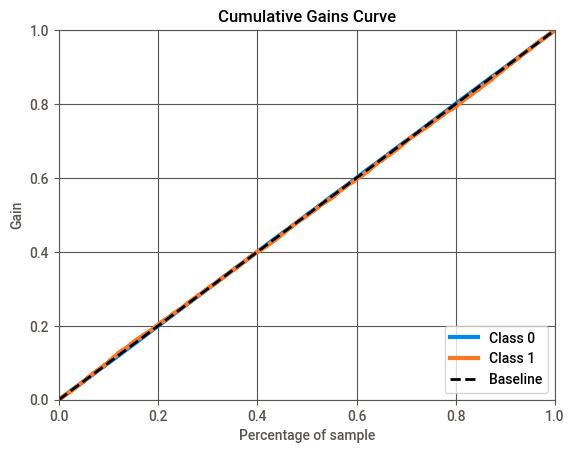

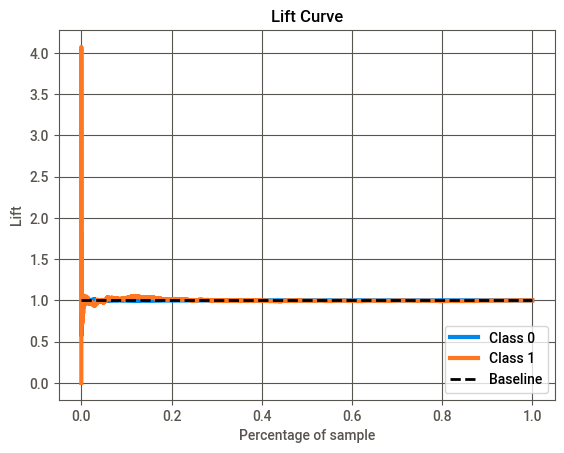

In [69]:
plt.figure(figsize=(20,10))

skplt.metrics.plot_cumulative_gain(y_val, yhat_dummy)

skplt.metrics.plot_lift_curve(y_val, yhat_dummy)

In [70]:
metrics_dummy = model_metrics('Dummy Classifier', y_val, yhat_dummy, x_validation)

## 7.2 LogisticRegression

In [71]:
model_lr = LogisticRegression()

model_lr.fit(X_train, y_train)

yhat_lr = model_lr.predict_proba(X_val)

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

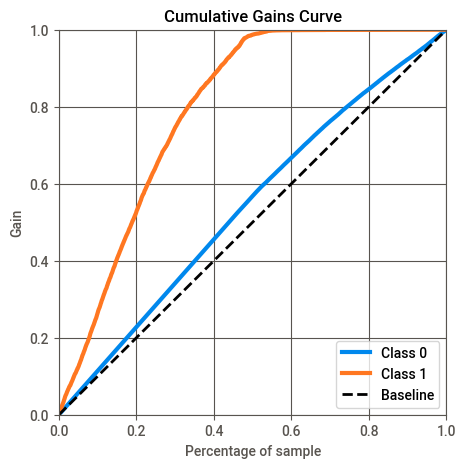

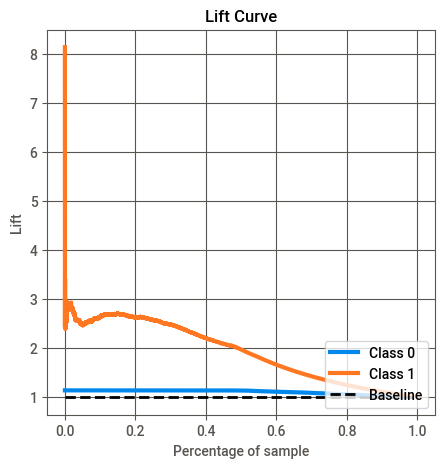

In [72]:
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, figsize=(5,5))

skplt.metrics.plot_lift_curve(y_val, yhat_lr, figsize=(5,5))

In [73]:
metrics_lr = model_metrics('Logistic Regression', y_val, yhat_lr, x_validation)

## 7.3 Random Forest

In [74]:
model_rf = RandomForestClassifier()

model_rf.fit(X_train, y_train)

yhat_rf = model_rf.predict_proba(X_val)

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

<Figure size 2000x1000 with 0 Axes>

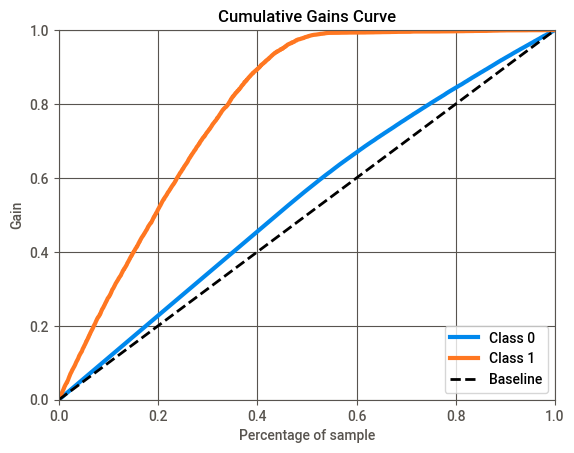

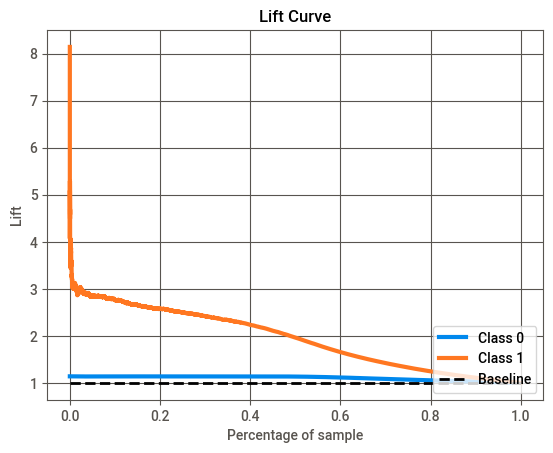

In [75]:
plt.figure(figsize=(20,10))

skplt.metrics.plot_cumulative_gain(y_val, yhat_rf)

skplt.metrics.plot_lift_curve(y_val, yhat_rf)

In [76]:
metrics_rf = model_metrics('Random Forest', y_val, yhat_rf, x_validation)

## 7.4 XGBoost

In [77]:
model_xgb = XGBClassifier()

model_xgb.fit(X_train, y_train)

yhat_xgb = model_xgb.predict_proba(X_val)

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

<Figure size 2000x1000 with 0 Axes>

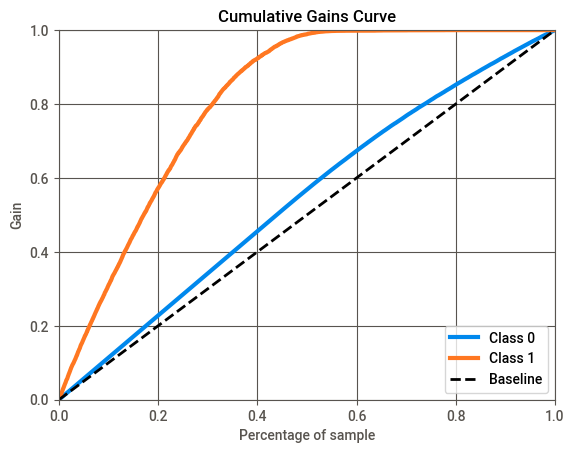

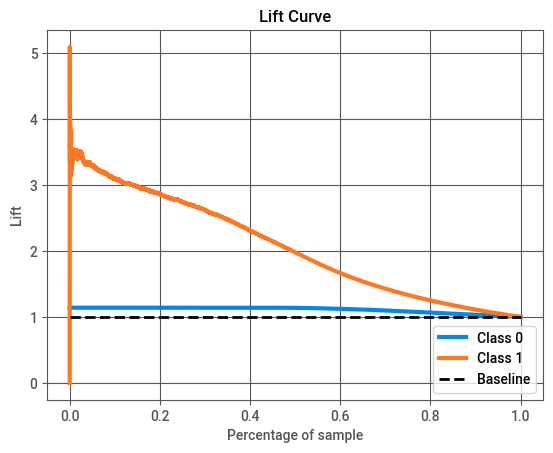

In [79]:
plt.figure(figsize=(20,10))

skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb)

skplt.metrics.plot_lift_curve(y_val, yhat_xgb)

In [80]:
metrics_xgb = model_metrics('XGBoost Classifier', y_val, yhat_xgb, x_validation)

## 7.5 Light GBM

In [81]:
model_lgb = lgb.LGBMClassifier()

model_lgb.fit(X_train, y_train)

yhat_lgb = model_lgb.predict_proba(X_val)

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

<Figure size 2000x1000 with 0 Axes>

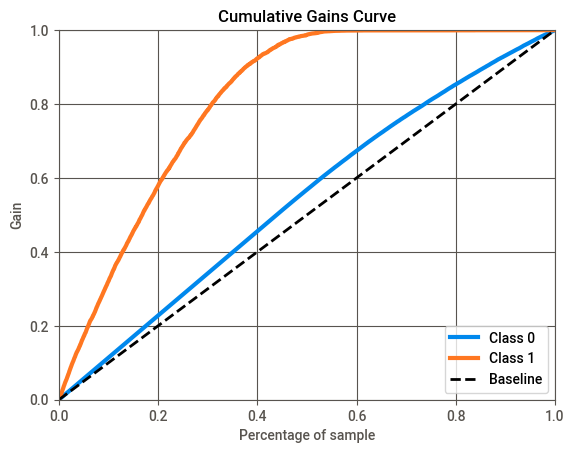

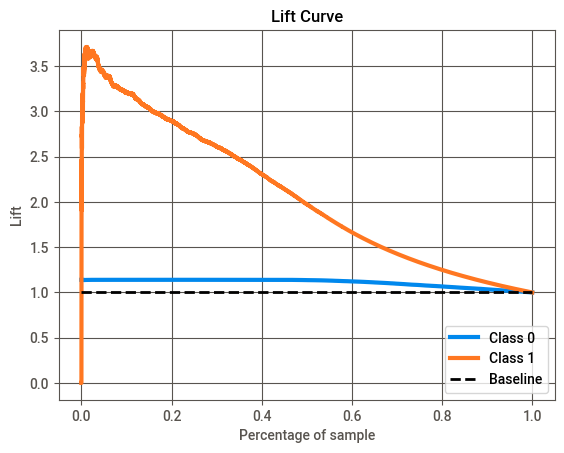

In [82]:
plt.figure(figsize=(20,10))

skplt.metrics.plot_cumulative_gain(y_val, yhat_lgb)

skplt.metrics.plot_lift_curve(y_val, yhat_lgb)

In [83]:
metrics_lgb = model_metrics('Light GBM', y_val, yhat_lgb, x_validation)

## 7.6 Compare Models

In [84]:
metrics_all = pd.concat([metrics_dummy, metrics_lr, metrics_rf, metrics_xgb, metrics_lgb], axis=0)
metrics_all.sort_values(by='F1 at K', ascending=False)

,Model Name,Precisão at K,Recall at K,F1 at K,Acurácia at K,ROC AUC at K
0,Light GBM,0.40900,0.218483,0.284819,0.876824,0.856095
0,XGBoost Classifier,0.39525,0.211138,0.275244,0.876185,0.854259
0,Random Forest,0.34825,0.186031,0.242514,0.866312,0.830897
0,Logistic Regression,0.31175,0.166533,0.217096,0.877185,0.833658
0,Dummy Classifier,0.12425,0.066373,0.086525,0.877202,0.500000


A curva de ganhos cumulativos mostra quanto da minha amostra eu precisaria pegar pra selecionar todas as pessoas interessadas em adquirir o seguro. Por exemplo no caso do LightGBM, se eu pegar cerca de 50% da minha base eu já estarei alcançando todas as pessoas interessadas.


Já a curva Lift mostra o quanto meu modelo é melhor que a aleatoriedade. Por exemplo no caso do Light GBM, pegando apenas 20% da amostra o meu modelo perfoma quase 3x mais que uma busca aleatória.

O modelo Light GBM Parece ter as melhores métricas entre os testados, além de possuir uma curva de ganhos cumulativos e curva lift melhor ou parecida com os melhores.

## 7.7 Cross Validation

In [85]:
model_list = [lgb.LGBMClassifier(), XGBClassifier(), RandomForestClassifier()]
model_name = ['LGBMClassifier', 'XGBoost Classifier', 'Random Forest Classifier' ]

cross_concat = pd.DataFrame()
cross_list = []

for i, name in zip(model_list, model_name):
    
    cross_val = cross_validation(X, y, 5, name, i)
    cross_list.append(cross_val)

df_cross_validation = pd.concat(cross_list, ignore_index=True)    

In [86]:
round(df_cross_validation.groupby('Model Name').agg(['mean', 'std']).reset_index().sort_values(by=('F1 at K','mean'), ascending=False),3)

Model Name Precisão at K        Recall at K        F1 at K  \
                                     mean    std        mean    std    mean   
0            LGBMClassifier         0.401  0.003       0.269  0.005   0.322   
2        XGBoost Classifier         0.392  0.004       0.263  0.005   0.315   
1  Random Forest Classifier         0.350  0.008       0.235  0.007   0.281   

         Acurácia at K        ROC AUC at K         
     std          mean    std         mean    std  
0  0.004         0.878  0.002        0.855  0.002  
2  0.004         0.877  0.002        0.853  0.002  
1  0.008         0.869  0.002        0.833  0.001

Podemos ver que o Cross Validation deu valores bem próximos do treino, mostrando que o modelo está com uma boa performance(não está com Overfitting nem Underfitting)

# 8.0 MODEL PERFORMANCE

Modelo Escolhido Baseado nas métricas - Light GBM

In [87]:
param_distributions = {'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.4],
             'num_leaves': [20, 30, 40, 50, 60],
             'max_depth':[-1, 0, 1, 2, 3],
             'min_child_samples':[10, 20, 30, 40, 50],
             'subsample':[0.15, 0.30, 0.65, 0.85, 1],
             'colsample_bytree':[0.15, 0.30, 0.65, 0.85, 1],
             'reg_alpha': [0, 1, 2, 3, 4, 5]}

#Random Search
random_search = ms.RandomizedSearchCV(model_lgb, param_distributions=param_distributions, n_iter=5, cv=5)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=5,
                   param_distributions={'colsample_bytree': [0.15, 0.3, 0.65,
                                                             0.85, 1],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.4],
                                        'max_depth': [-1, 0, 1, 2, 3],
                                        'min_child_samples': [10, 20, 30, 40,
                                                              50],
                                        'num_leaves': [20, 30, 40, 50, 60],
                                        'reg_alpha': [0, 1, 2, 3, 4, 5],
                                        'subsample': [0.15, 0.3, 0.65, 0.85,
                                                      1]})

In [88]:
best_params = random_search.best_params_
best_score = random_search.best_score_

print(best_params)
print(best_score)

{'subsample': 0.15, 'reg_alpha': 0, 'num_leaves': 20, 'min_child_samples': 30, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 0.85}
0.8783029734401145


In [89]:
#passar random state
model_lgb_tunned = lgb.LGBMClassifier(subsample=1, reg_alpha=4, num_leaves=40, min_child_samples=10,  max_depth=0, learning_rate=0.1, colsample_bytree=0.3, random_state=42)

In [90]:
model_lgb_tunned.fit(X_train, y_train)

yhat_lgb_tunned = model_lgb_tunned.predict_proba(X_val)



In [91]:
metrics_lgb = model_metrics('Light GBM', y_val, yhat_lgb_tunned, x_validation)

In [92]:
metrics_lgb

,Model Name,Precisão at K,Recall at K,F1 at K,Acurácia at K,ROC AUC at K
0,Light GBM,0.40525,0.21648,0.282208,0.877218,0.8565


Esse foi o modelo final escolhido, usando os dados de validação para ajustar os hiperparâmetros, podemos ver que ele teve uma performace parecida com os dados de treino. Mostrando que ele está com uma boa capacidade de generalização. Porém só podemos concluir isso aplicando a dados nunca vistos.

## 8.1 Testing on Raw Data

In [93]:
x_test = X_test.copy()

In [94]:
rename_columns(x_test)
rename_categorical(x_test)
data_encoding(x_test)
data_rescalling(x_test)
x_test = x_test.loc[:,cols_selected]

In [95]:
x = X.loc[:,cols_selected]

In [96]:
x_test

,vehicle_age,annual_premium,age,previously_insured,policy_sales_channel,vehicle_damage,vintage,gender,region_code
200222,0,-0.750984,0.015385,1,0.057146,0,0.214533,0,0.024274
49766,1,0.388730,0.538462,0,0.209127,1,0.318339,1,0.034919
172201,1,-1.936579,0.323077,0,0.209127,1,0.276817,0,0.024274
160713,0,-1.936579,0.092308,0,0.010194,0,0.892734,0,0.024224
53272,1,0.155852,0.476923,0,0.194157,1,0.882353,1,0.003398
...,...,...,...,...,...,...,...,...,...
258403,0,-0.550383,0.046154,0,0.353663,1,0.560554,1,0.034919
234155,0,0.036746,0.000000,1,0.057146,0,0.771626,0,0.034919
24476,0,1.193798,0.123077,1,0.353663,0,0.674740,0,0.088891
60423,0,0.062221,0.015385,1,0.057146,0,0.152249,0,0.024274


In [97]:
#training on total dataset
model_lgb_tunned.fit(x, y)

yhat_lgb_tunned = model_lgb_tunned.predict_proba(x_test)


In [98]:
x_test_validation = X_test.copy()
x_test_validation['response'] = y_test.copy()

In [99]:
metrics_lgb_tunned = model_metrics('Light GBM', y_test, yhat_lgb_tunned, x_test_validation)

In [100]:
metrics_lgb_tunned

,Model Name,Precisão at K,Recall at K,F1 at K,Acurácia at K,ROC AUC at K
0,Light GBM,0.432,0.181455,0.255565,0.875075,0.859773


<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

<Figure size 2000x1000 with 0 Axes>

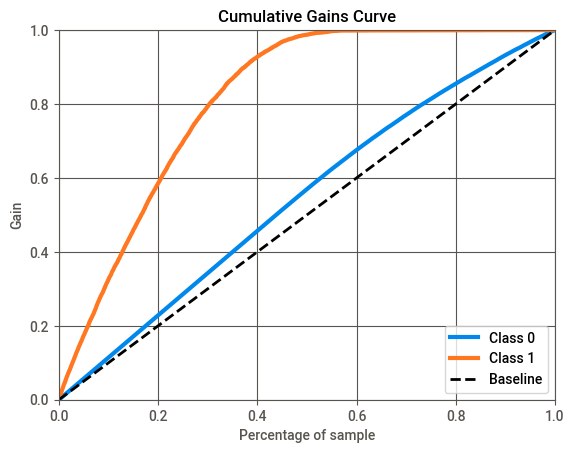

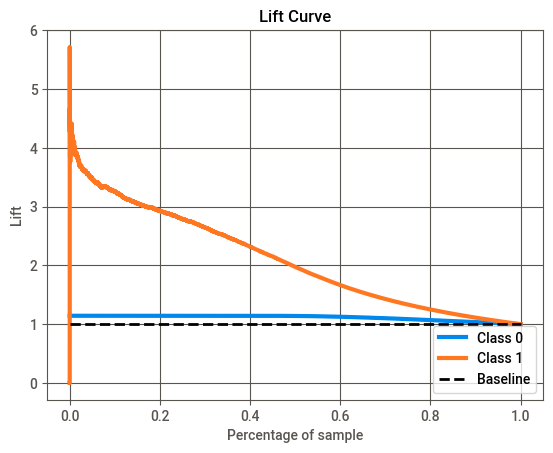

In [101]:
plt.figure(figsize=(20,10))

skplt.metrics.plot_cumulative_gain(y_test, yhat_lgb_tunned)

skplt.metrics.plot_lift_curve(y_test, yhat_lgb_tunned)

Testando o modelo em dados nunca vistos, podemos concluir que ele está com uma boa capacidade de generalização, ou seja, que ele aprendeu com os dados de treino e é capaz de fazer uma boa previsão para dados nunca vistos.

## 8.2 Business Performance

In [102]:
x_test['id'] = X_test['id'].copy()
x_test['score'] = yhat_lgb_tunned[:,1]
x_test = x_test.sort_values(by='score', ascending=False)

In [103]:
estimated_insurance = 540.00
cost_call = 40.00

In [104]:
x_test['estimated_profit'] = x_test['score']*estimated_insurance - cost_call
x_test['cumulative_profit'] = x_test['estimated_profit'].cumsum()

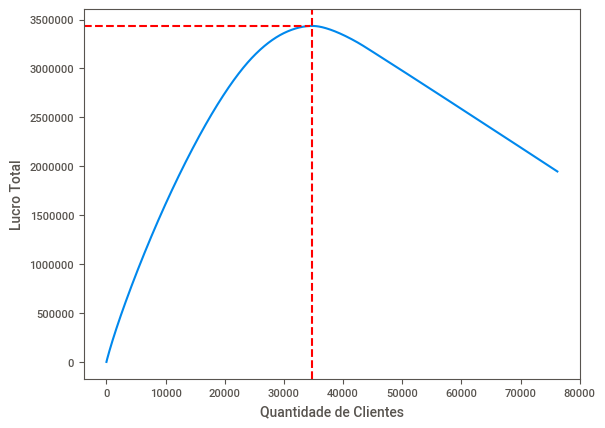

In [105]:
posicoes = np.arange(len(x_test)) + 1
plt.plot(posicoes, x_test['cumulative_profit'])

plt.xlabel('Quantidade de Clientes')
plt.ylabel('Lucro Total')

indice_maximo = np.argmax(x_test['cumulative_profit'])
x_maximo = posicoes[indice_maximo]
y_maximo = x_test['cumulative_profit'].iloc[indice_maximo]
# Adicionar linha vertical até o eixo x
plt.axvline(x=x_maximo, ymin=0, ymax=y_maximo / np.max(x_test['cumulative_profit']), color='red', linestyle='--')

# Adicionar linha horizontal até o eixo y
plt.axhline(y=y_maximo, xmin=0, xmax=x_maximo / np.max(posicoes), color='red', linestyle='--')

In [106]:
print(f'Quantidade Ideal da base de clientes para ligar: {100*round(x_maximo/x_test.shape[0],2):.2f}%')
print(f'Lucro Total ligando para 100% Clientes: R${round(x_test["cumulative_profit"].iloc[76221]):.2f}')
print(f'Lucro Total ligando para 46% Clientes: R${round(y_maximo):.2f}')

Quantidade Ideal da base de clientes para ligar: 46.00%
Lucro Total ligando para 100% Clientes: R$1946932.00
Lucro Total ligando para 46% Clientes: R$3434576.00


A partir das previsões feitas pelo modelo podemos tirar algumas conclusões.

Considerando-se que para cada cliente que a empresa consiga vender o seguro de carro ela tenho um Lucro Bruto de 540,00 Reais. Vamos considerar também que a empresa pretende ligar para esses potenciais clientes e cada ligação tenha um custo total de 40,00 Reais.

Ou seja, a empresa precisa ligar para 46% da base de clientes(que são os que tem a maior probabilidade de aceitar o seguro) para ter o lucro máximo:

→ Lucro ligando até o cliente 35103: 3.429.452,90 Reais.

→ Lucro Ligando para a base toda de clientes: 1.962.802,77.

É um lucro 1.74 vezes maior usando o modelo.